In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingClassifier
from sklearn.linear_model import SGDRegressor, LinearRegression, BayesianRidge, Lasso, HuberRegressor
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
import seaborn as sns
sns.set(color_codes = True)
from scipy import stats
import xgboost as xgb 
np.random.seed(25)

In [54]:
train9 = pd.read_csv("train9.csv")
train1 = pd.read_csv("train1.csv")
test9  = pd.read_csv("test9.csv")
test1 = pd.read_csv("test1.csv")
data = pd.read_csv("hero_data.csv")

In [55]:
train = train9.append(train1)
train = train.append(test9)
train = train.sort_values('user_id')
train = pd.merge(train,data, how = 'left', on = 'hero_id')

test = test1 
test = pd.merge(test,data, how ='left', on = 'hero_id')

print (train.isnull().sum(axis = 0), test.isnull().sum(axis = 0) )

user_id                  0
hero_id                  0
id                       0
num_games                0
num_wins                 0
kda_ratio                0
primary_attr             0
attack_type              0
roles                    0
base_health              0
base_health_regen        0
base_mana                0
base_mana_regen          0
base_armor               0
base_magic_resistance    0
base_attack_min          0
base_attack_max          0
base_strength            0
base_agility             0
base_intelligence        0
strength_gain            0
agility_gain             0
intelligence_gain        0
attack_range             0
projectile_speed         0
attack_rate              0
move_speed               0
turn_rate                0
dtype: int64 user_id                  0
hero_id                  0
id                       0
num_games                0
primary_attr             0
attack_type              0
roles                    0
base_health              0
base_health_reg

In [56]:
def splitroles(text):
    try:
        x = text.split(":")
        if len(x) == 6:
            return x
        else:
            for i in range(6-len(x)):
                x.append("No label")
            return x
    except:
        return ("No label", "No label", "No label", "No label", "No label", "No label")

In [57]:
train['role_1'], train['role_2'], train['role_3'], train['role_4'], train['role_5'], train['role_6'] = \
zip(*train['roles'].apply(lambda x: splitroles(x)))
test['role_1'], test['role_2'], test['role_3'], test['role_4'], test['role_5'], test['role_6'] = \
zip(*test['roles'].apply(lambda x: splitroles(x)))

train.head(5)

user_id  hero_id     id  num_games  num_wins    kda_ratio primary_attr  \
0        1       74   1_74        304       185  3743.699732          int   
1        1       65   1_65        255       151  4009.021513          int   
2        1       39   1_39        203       135  5094.621514          int   
3        1      106  1_106        158       106  4619.212963          agi   
4        1        2    1_2        157        94  2871.627907          str   

  attack_type                                  roles  base_health    ...     \
0      Ranged     Carry:Nuker:Disabler:Escape:Pusher          200    ...      
1      Ranged      Initiator:Jungler:Disabler:Escape          200    ...      
2      Ranged                     Carry:Nuker:Escape          200    ...      
3       Melee  Carry:Escape:Nuker:Disabler:Initiator          200    ...      
4       Melee     Initiator:Durable:Disabler:Jungler          200    ...      

   projectile_speed  attack_rate  move_speed  turn_rate     role_1   role_2  \
0               900          1.7         280        0.5      Carry    Nuker   
1               900          1.7         290        1.0  Initiator  Jungler   
2              1500          1.5         295        0.5      Carry    Nuker   
3               900          1.7         305        0.5      Carry   Escape   
4               900          1.7         290        0.6  Initiator  Durable   

     role_3    role_4     role_5    role_6  
0  Disabler    Escape     Pusher  No label  
1  Disabler    Escape   No label  No label  
2    Escape  No label   No label  No label  
3     Nuker  Disabler  Initiator  No label  
4  Disabler   Jungler   No label  No label  

[5 rows x 34 columns]

In [58]:
cat = [f for f in train.columns if train.dtypes[f] == 'object']
non_cat = [k for k in train.columns if train.dtypes[k] != 'object']
print ( "There are {} numeric and {} categorical columns in train data ".format(len(non_cat), len(cat)))

There are 24 numeric and 10 categorical columns in train data 


In [59]:
train = train.drop(['roles', 'id'], axis = 1)
test = test.drop(['roles', 'id'], axis = 1 )

In [60]:
cat = [f for f in train.columns if train.dtypes[f] == 'object']
non_cat = [k for k in train.columns if train.dtypes[k] != 'object']
print ( "There are {} numeric and {} categorical columns in train data ".format(len(non_cat), len(cat)))

There are 24 numeric and 8 categorical columns in train data 


In [49]:
train.get_dtype_counts()

float64     9
int64      15
object      8
dtype: int64

In [61]:
primary_attr_summary = train.groupby('primary_attr')
attack_type_summary = train.groupby('attack_type')
print(primary_attr_summary.mean(), attack_type_summary.mean())

                  user_id    hero_id   num_games    num_wins    kda_ratio  \
primary_attr                                                                
agi           1529.351863  46.386346  173.951272   99.261270  3814.690080   
int           1503.183868  49.333967  202.426615  112.986398  3476.592481   
str           1430.100772  53.716552  188.688107  107.152516  3147.055896   

              base_health  base_health_regen  base_mana  base_mana_regen  \
primary_attr                                                               
agi                 200.0           1.823200       75.0              0.9   
int                 200.0           1.569890       75.0              0.9   
str                 200.0           1.700686       75.0              0.9   

              base_armor    ...      base_agility  base_intelligence  \
primary_attr                ...                                        
agi            -0.529662    ...         21.750022          16.591332   
int            -0

In [62]:
train_primary_attr_agi = train[train['primary_attr'] == 'agi']
train_primary_attr_int = train[train['primary_attr'] == 'int']
train_primary_attr_str = train[train['primary_attr'] == 'str']
train_attack_type_Ranged = train[train['attack_type'] == 'Ranged']
train_attack_type_Melee = train[train['attack_type'] == 'Melee']

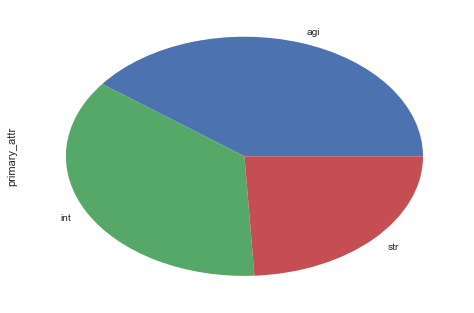

In [63]:
train["primary_attr"].value_counts().plot(kind='pie')

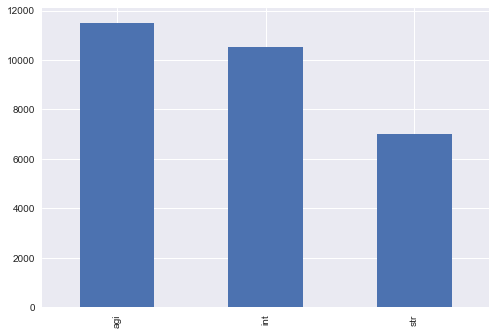

In [64]:
train["primary_attr"].value_counts().plot(kind='bar')

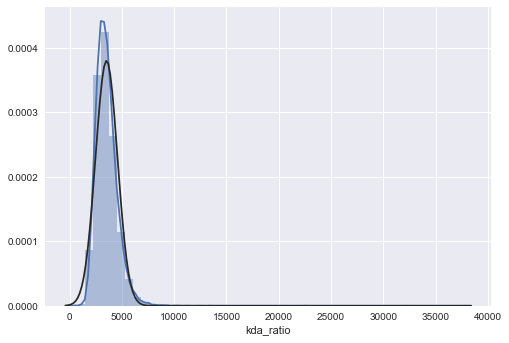

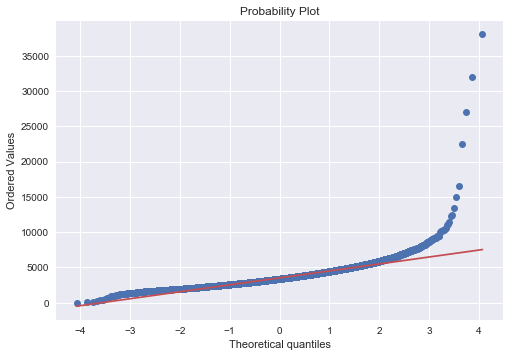

In [65]:
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

#histogram and normal probability plot
sns.distplot(train['kda_ratio'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['kda_ratio'], plot=plt)

In [16]:
sns.pairplot(train, hue="primary_attr", size=3)

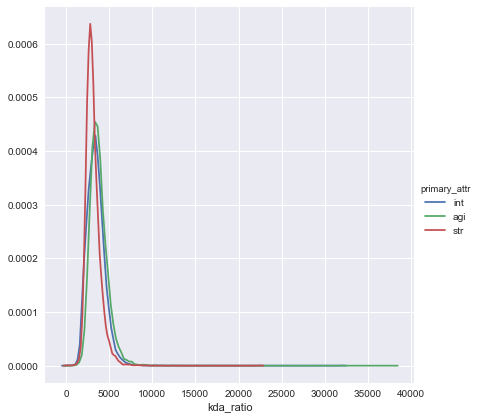

In [66]:
sns.FacetGrid(train, hue="primary_attr", size=6) \
   .map(sns.kdeplot, "kda_ratio") \
   .add_legend()

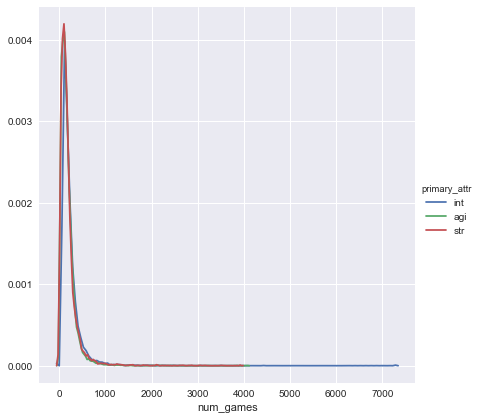

In [67]:
sns.FacetGrid(train, hue="primary_attr", size=6) \
   .map(sns.kdeplot, "num_games") \
   .add_legend()

In [68]:
train.columns

Index(['user_id', 'hero_id', 'num_games', 'num_wins', 'kda_ratio',
       'primary_attr', 'attack_type', 'base_health', 'base_health_regen',
       'base_mana', 'base_mana_regen', 'base_armor', 'base_magic_resistance',
       'base_attack_min', 'base_attack_max', 'base_strength', 'base_agility',
       'base_intelligence', 'strength_gain', 'agility_gain',
       'intelligence_gain', 'attack_range', 'projectile_speed', 'attack_rate',
       'move_speed', 'turn_rate', 'role_1', 'role_2', 'role_3', 'role_4',
       'role_5', 'role_6'],
      dtype='object')

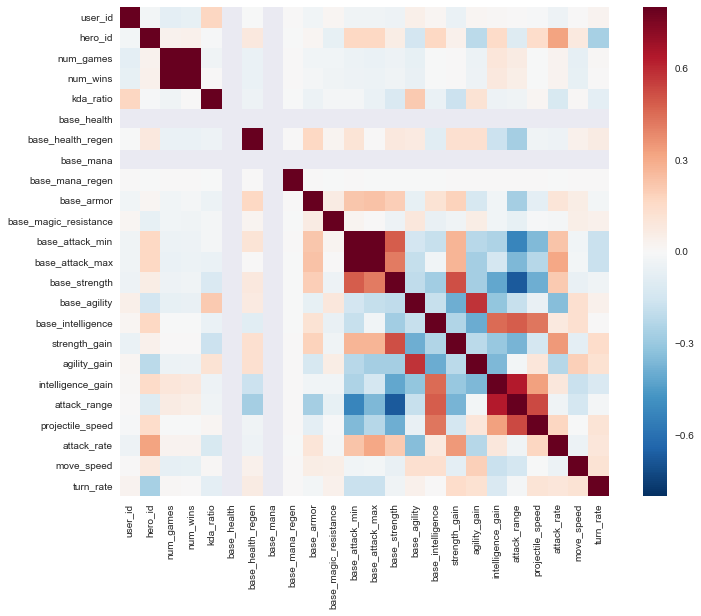

In [69]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

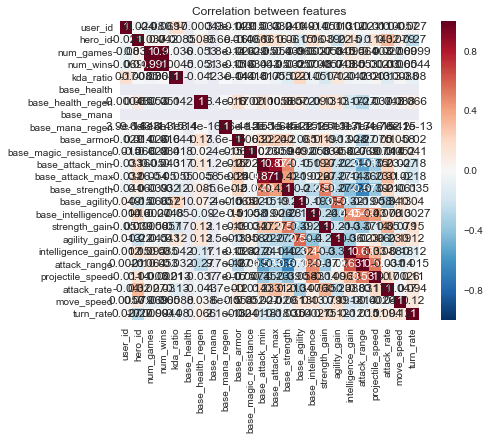

In [70]:
sns.heatmap(corrmat, vmax=1, square=True,annot=True)
plt.title('Correlation between features')

In [35]:
train['base_armor'].corr(train['base_magic_resistance'])

0.062697153040224815

In [39]:
non_cat = [f for f in train.columns if train.dtypes[f] != 'object']
non_cat.remove('user_id')
non_cat.remove('hero_id')
y = {}
for col in non_cat:
    if 'base_armor'not in col:
        x = train['base_armor'].corr(train[col])
        y[col] = x

In [80]:
y

{'agility_gain': -0.13267322691343822,
 'attack_range': -0.27414085902063562,
 'attack_rate': 0.10144390736692839,
 'base_agility': -0.065271916591960216,
 'base_attack_max': 0.23549131448101465,
 'base_attack_min': 0.2229927678978347,
 'base_health': nan,
 'base_health_regen': 0.16662158169378469,
 'base_intelligence': 0.11288010732505117,
 'base_magic_resistance': 0.062697153040224815,
 'base_mana': nan,
 'base_mana_regen': 1.7042224205324121e-16,
 'base_strength': 0.19877781043931048,
 'intelligence_gain': -0.027924447603453154,
 'kda_ratio': -0.043809055045779581,
 'move_speed': 0.057770074450492002,
 'num_games': -0.026206545542519416,
 'num_wins': -0.015916360883615994,
 'projectile_speed': -0.075054102164112069,
 'strength_gain': 0.18621504093361149,
 'turn_rate': -0.01955274628816352}

In [108]:
corr=train.corr()["kda_ratio"]
corr[np.argsort(corr, axis=0)[::-1]]

kda_ratio                1.000000e+00
base_attack_max         -5.497437e-02
user_id                  1.691162e-01
base_intelligence       -5.039264e-02
intelligence_gain       -4.206291e-02
projectile_speed         1.338872e-02
num_wins                 4.491923e-03
base_health_regen       -4.156321e-02
hero_id                 -8.548131e-03
base_armor              -4.380906e-02
base_mana_regen         -1.318232e-14
agility_gain             1.181483e-01
num_games               -3.641545e-02
base_health                       NaN
strength_gain           -1.689123e-01
base_mana                         NaN
turn_rate               -8.035490e-02
base_strength           -1.247880e-01
turn_rate               -8.035490e-02
base_magic_resistance   -1.771073e-02
attack_rate             -1.287908e-01
base_attack_min         -1.697960e-02
attack_range            -3.179936e-02
base_agility             2.077327e-01
Name: kda_ratio, dtype: float64

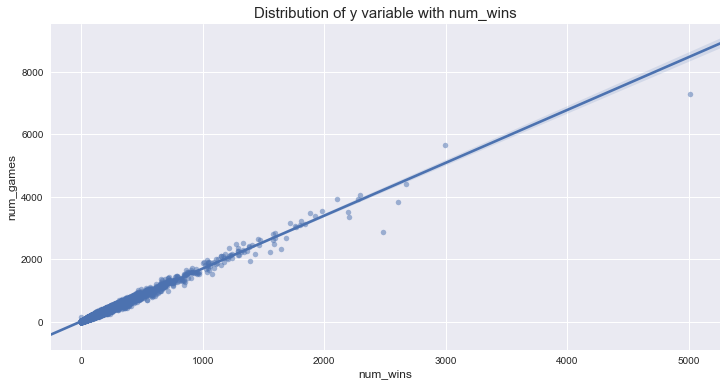

In [83]:
var_name = "num_wins"
plt.figure(figsize=(12,6))
sns.regplot(x=var_name, y='num_games', data=train, scatter_kws={'alpha':0.5, 's':30})
plt.xlabel(var_name, fontsize=12)
plt.ylabel('num_games', fontsize=12)
plt.title("Distribution of y variable with "+var_name, fontsize=15)
plt.show()

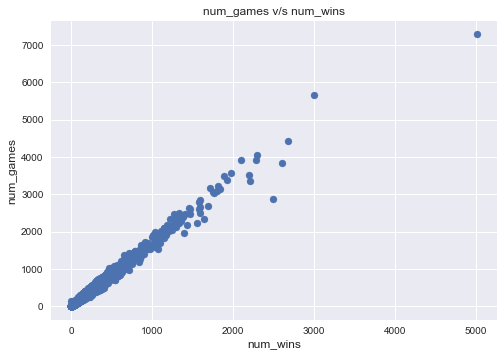

In [24]:
plt.scatter(train["num_wins"], train["num_games"])
plt.xlabel('num_wins', fontsize=12)
plt.ylabel('num_games', fontsize=12)
plt.title("num_games v/s num_wins")
plt.show()

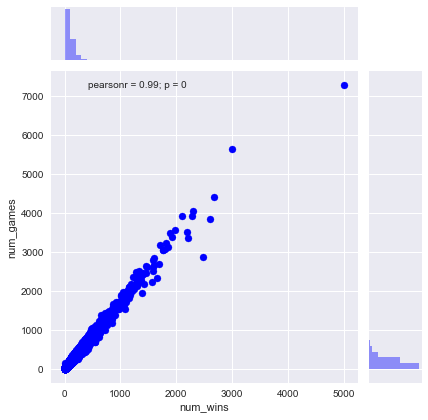

In [113]:
sns.jointplot(train['num_wins'],train['num_games'],color='blue')

In [25]:
len(train.loc[train['num_games'] > 4000])

4

In [71]:
train[train['num_games'] > 4000].shape[0]

4

In [79]:
train['primary_attr'].unique().size

3

In [74]:
len(train['primary_attr'].unique())

3

In [76]:
train.groupby(['primary_attr']).size()

primary_attr
agi    11513
int    10513
str     6996
dtype: int64

In [77]:
train.groupby(['primary_attr']).size()[0]/(train.groupby(['primary_attr']).size()[0] + train.groupby(['primary_attr']).size()[1]+ train.groupby(['primary_attr']).size()[2])        

0.39669905588863619

In [27]:
train[['primary_attr', 'base_health']].groupby(['primary_attr'],
                                               as_index = False).mean().sort_values(by = 'primary_attr', ascending = False)

primary_attr  base_health
2          str          200
1          int          200
0          agi          200

In [28]:
train[['primary_attr', 'base_health_regen']].groupby(['primary_attr'],
                                               as_index = False).mean().sort_values(by = 'primary_attr', ascending = False)

primary_attr  base_health_regen
2          str           1.700686
1          int           1.569890
0          agi           1.823200

In [29]:
train[['primary_attr', 'base_mana']].groupby(['primary_attr'],
                                               as_index = False).mean().sort_values(by = 'primary_attr', ascending = False)

primary_attr  base_mana
2          str         75
1          int         75
0          agi         75

In [30]:
train[['primary_attr', 'base_armor']].groupby(['primary_attr'],
                                               as_index = False).mean().sort_values(by = 'primary_attr', ascending = False)

primary_attr  base_armor
2          str    0.218982
1          int   -0.012271
0          agi   -0.529662

In [31]:
train[['primary_attr', 'base_magic_resistance']].groupby(['primary_attr'],
                                               as_index = False).mean().sort_values(by = 'primary_attr', ascending = False)

primary_attr  base_magic_resistance
2          str              25.000000
1          int              24.880148
0          agi              25.000000

In [29]:
#train.loc[train['num_games'] > 4000, 'num_games'] = train['num_games'].mean()

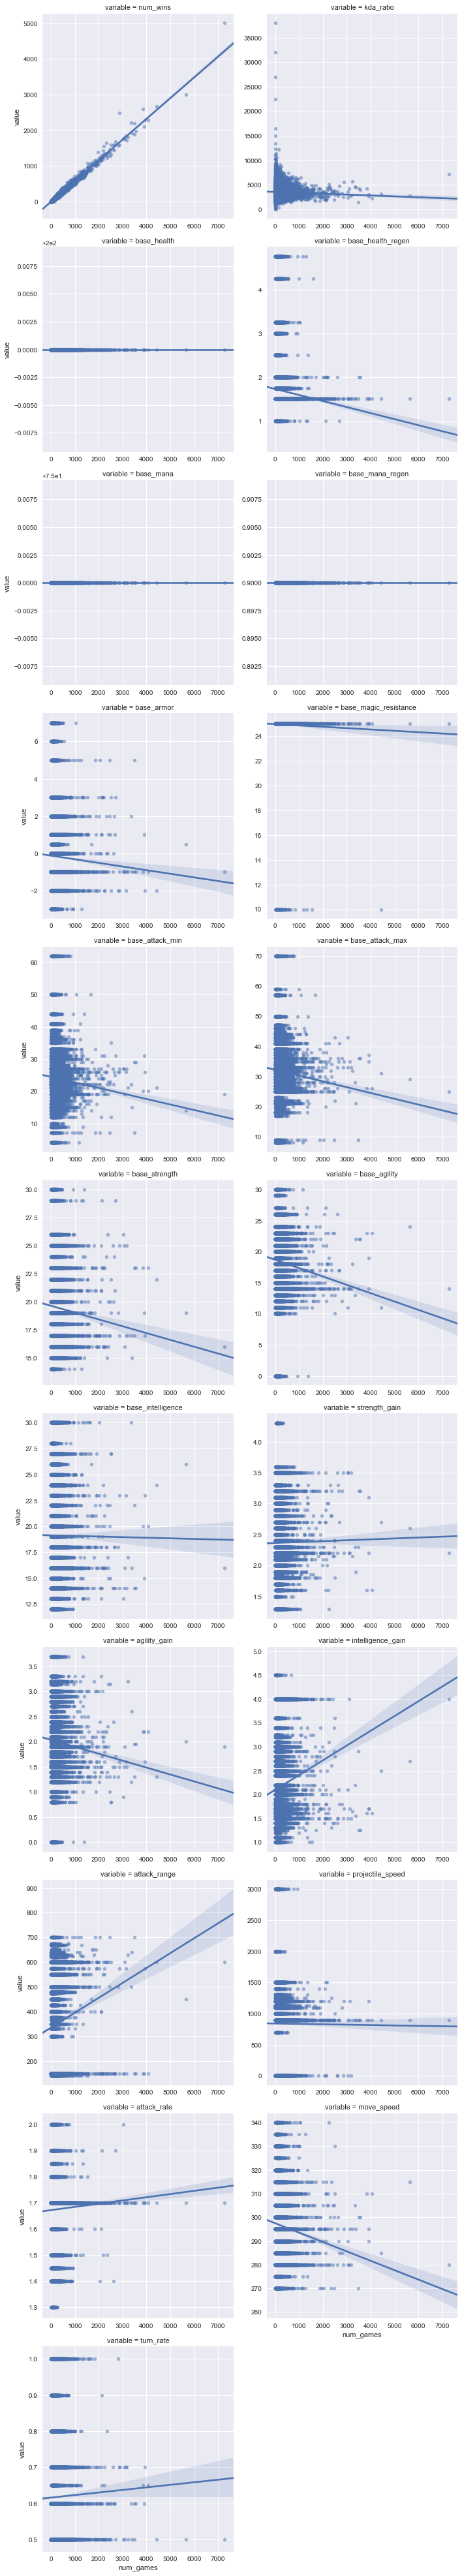

In [26]:
non_cat = [f for f in train.columns if train.dtypes[f] != 'object']
non_cat.remove('user_id')
non_cat.remove('hero_id')
non_cat.remove('num_games')
p = pd.melt(train, id_vars='num_games', value_vars=non_cat)
g = sns.FacetGrid (p, col='variable', col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(sns.regplot, 'num_games','value', scatter_kws={'alpha':0.5, 's':30})
g

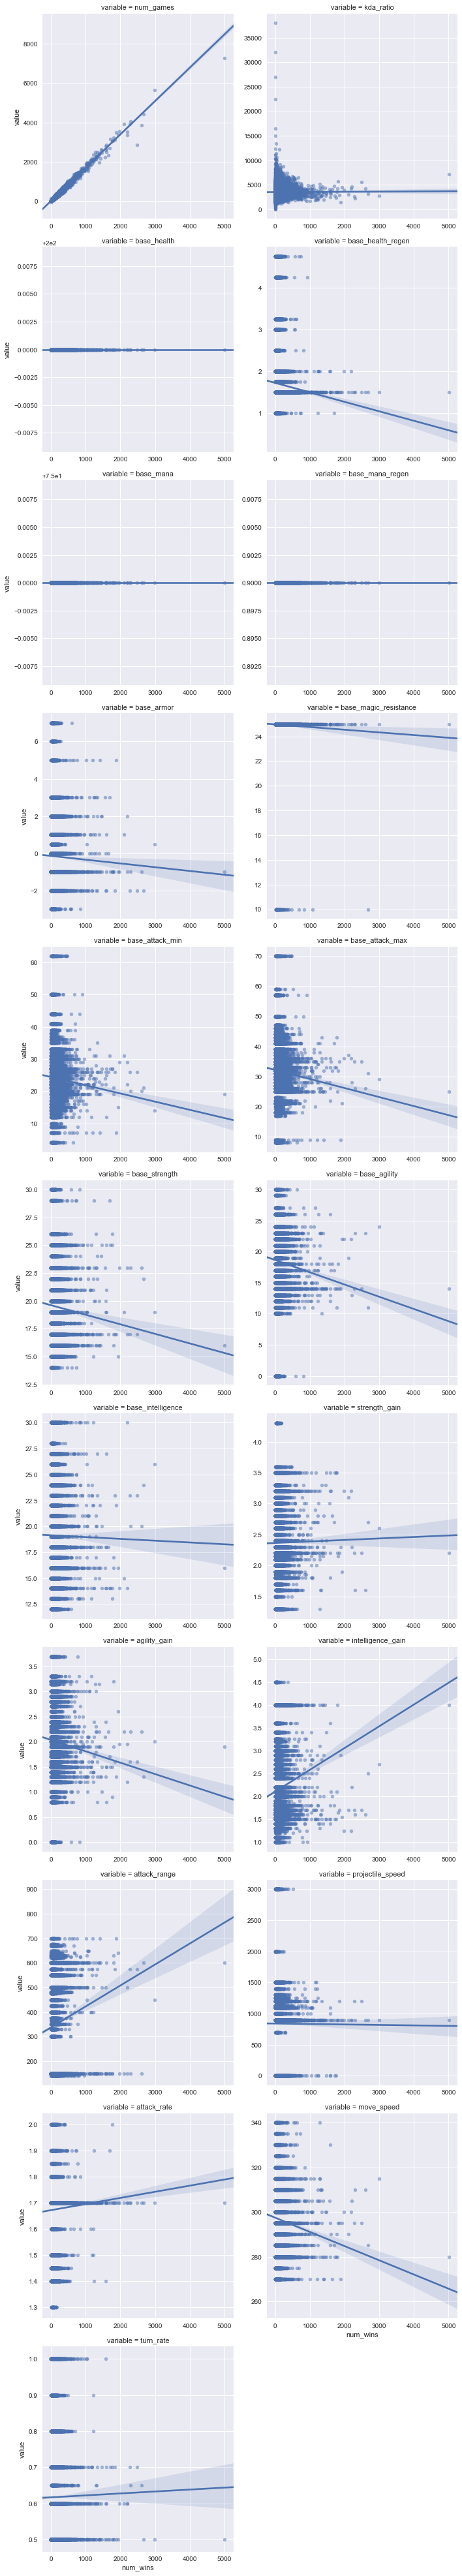

In [22]:
non_cat = [f for f in train.columns if train.dtypes[f] != 'object']
non_cat.remove('user_id')
non_cat.remove('hero_id')
non_cat.remove('num_wins')
p = pd.melt(train, id_vars='num_wins', value_vars=non_cat)
g = sns.FacetGrid (p, col='variable', col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(sns.regplot, 'num_wins','value', scatter_kws={'alpha':0.5, 's':30})
g

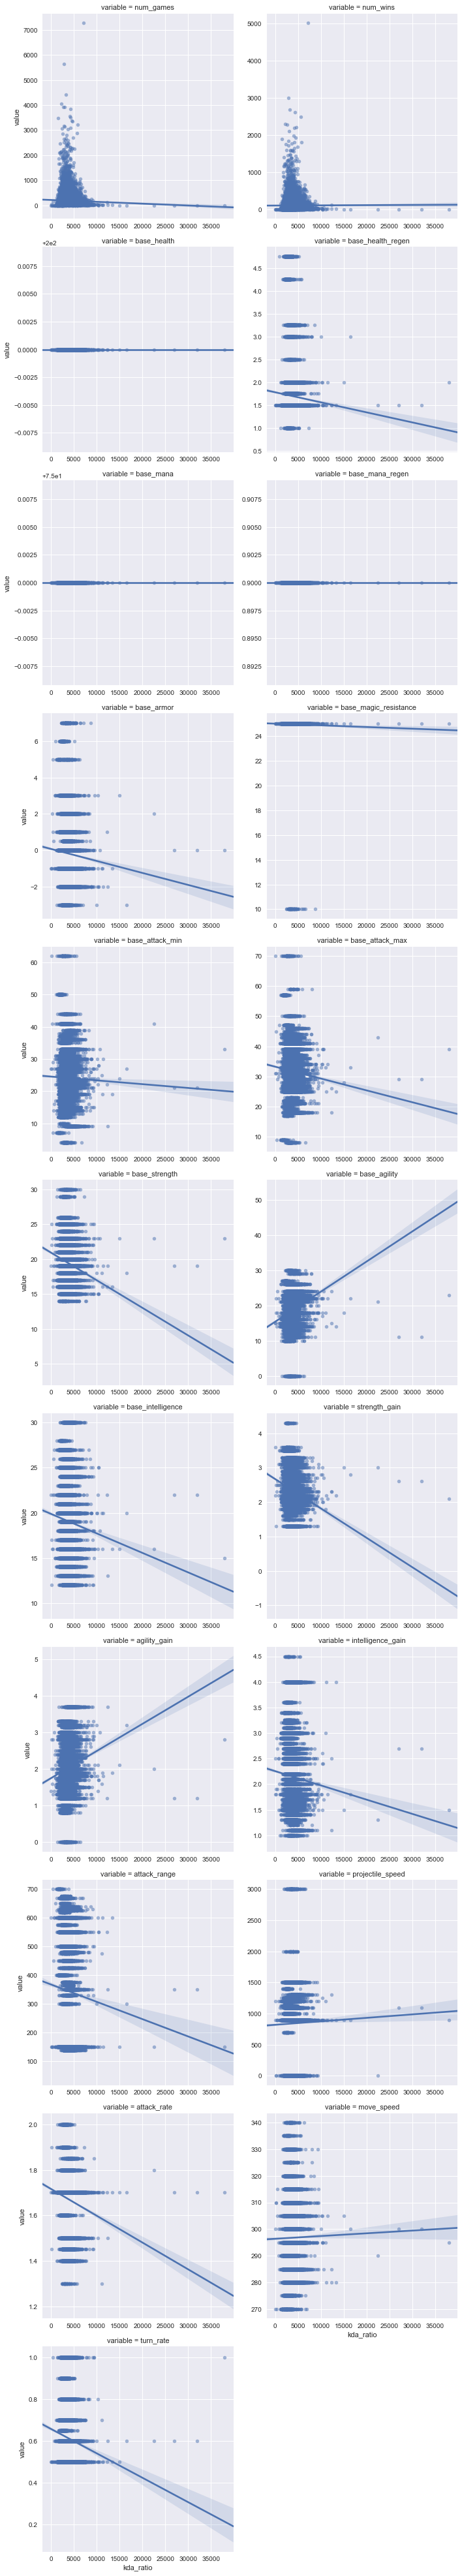

In [85]:
non_cat = [f for f in train.columns if train.dtypes[f] != 'object']
non_cat.remove('user_id')
non_cat.remove('hero_id')
non_cat.remove('kda_ratio')
p = pd.melt(train, id_vars='kda_ratio', value_vars=non_cat)
g = sns.FacetGrid (p, col='variable', col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(sns.regplot, 'kda_ratio','value', scatter_kws={'alpha':0.5, 's':30})
g

C:\Users\Architect_shwet\Anaconda3\lib\site-packages\scipy\stats\stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
C:\Users\Architect_shwet\Anaconda3\lib\site-packages\scipy\stats\stats.py:5277: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0
C:\Users\Architect_shwet\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


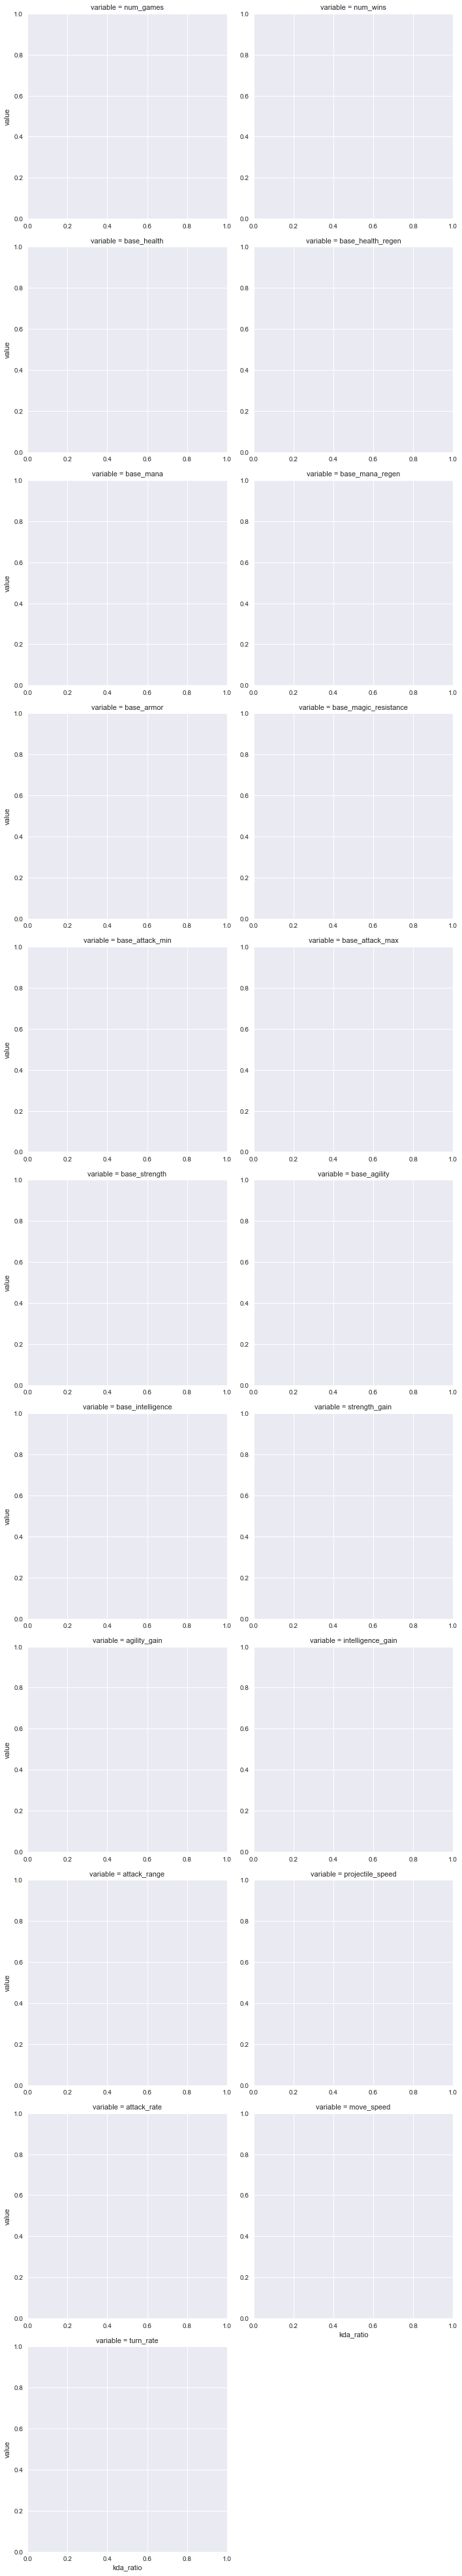

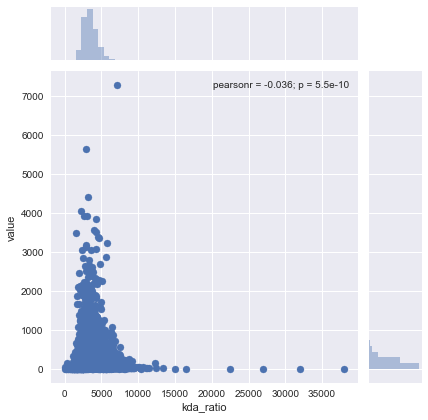

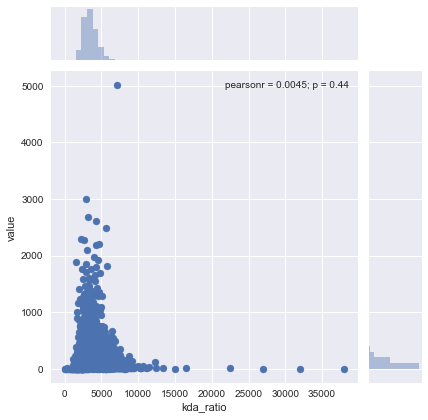

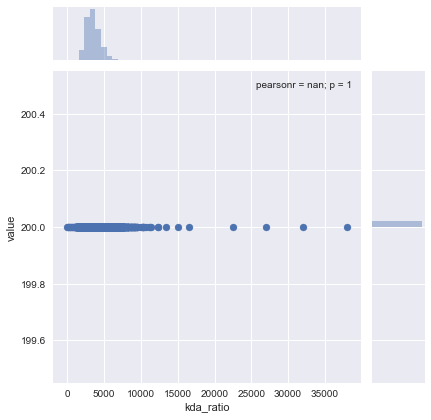

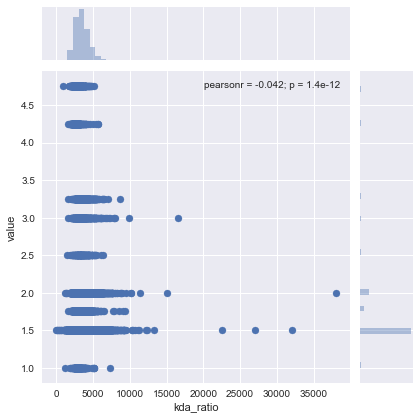

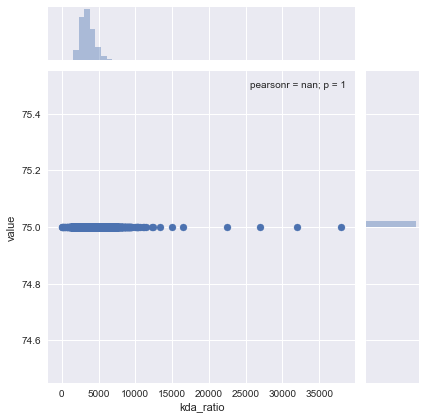

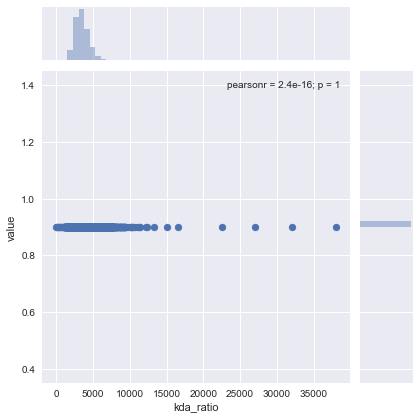

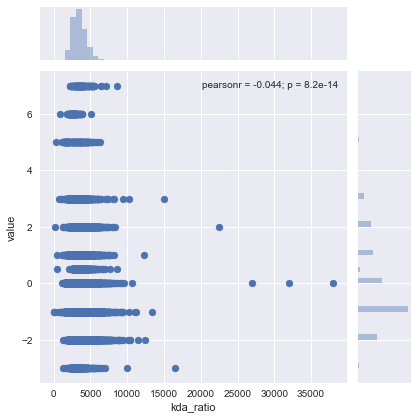

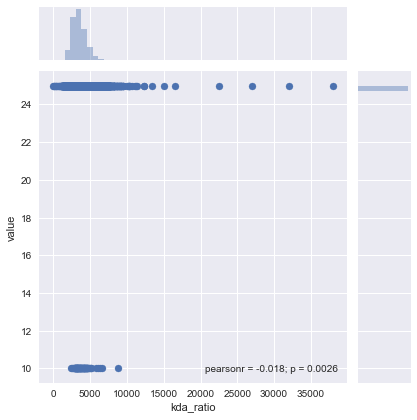

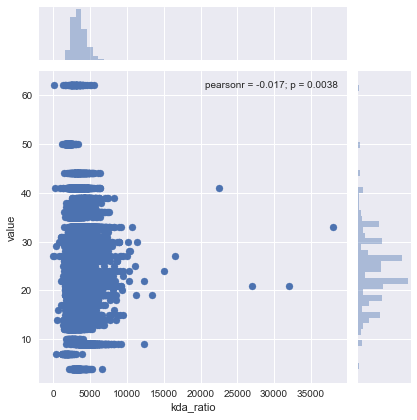

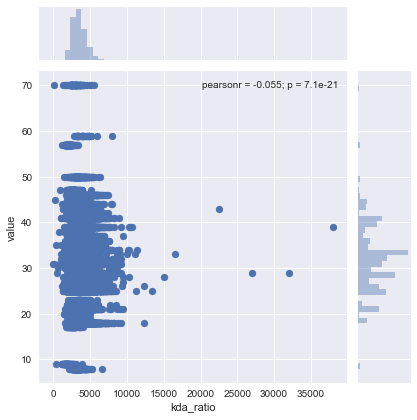

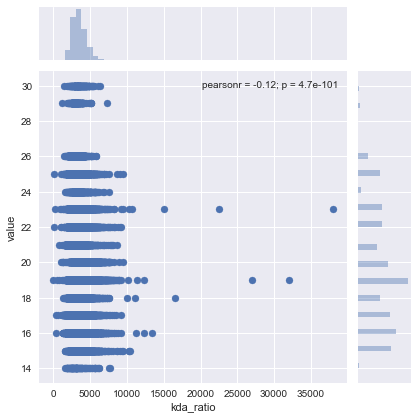

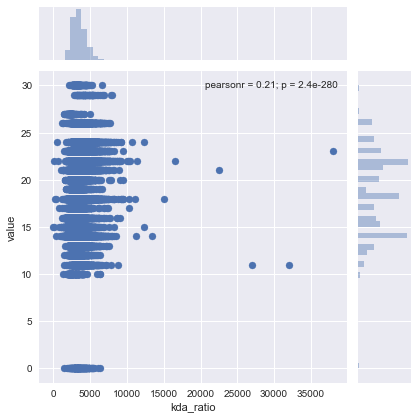

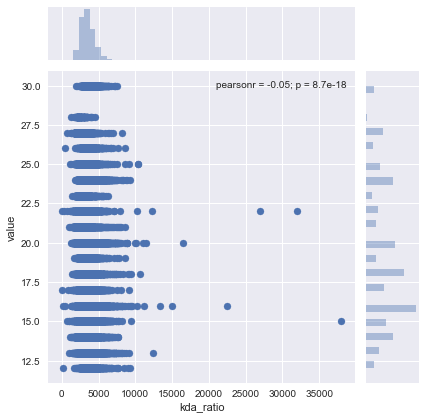

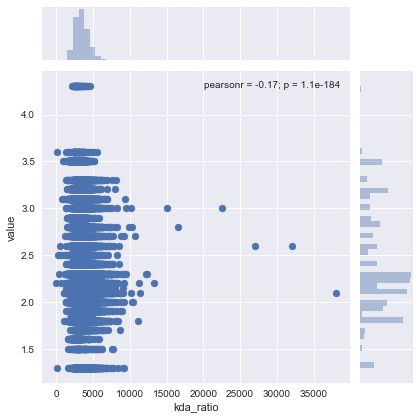

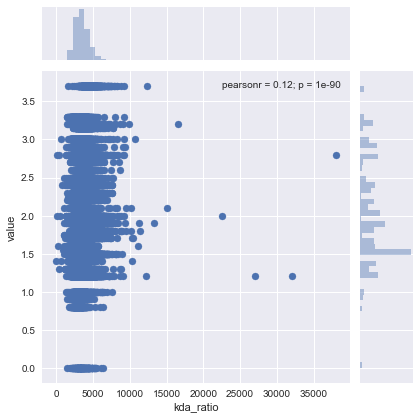

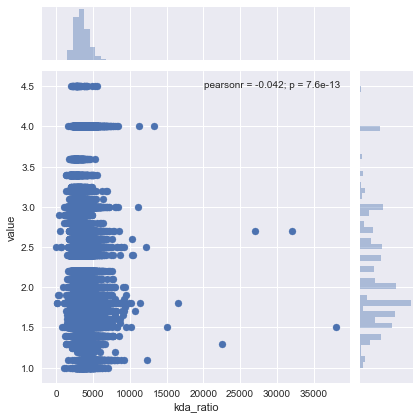

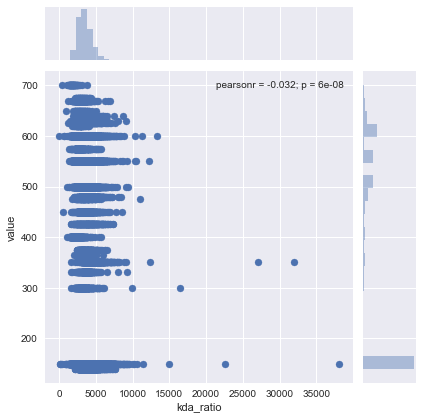

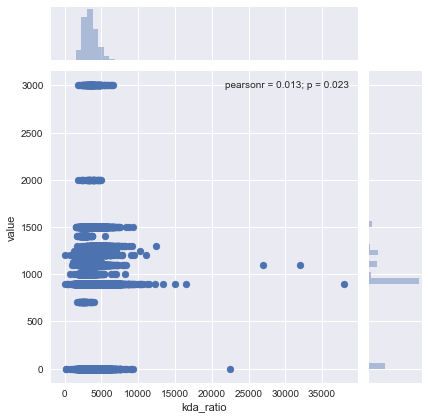

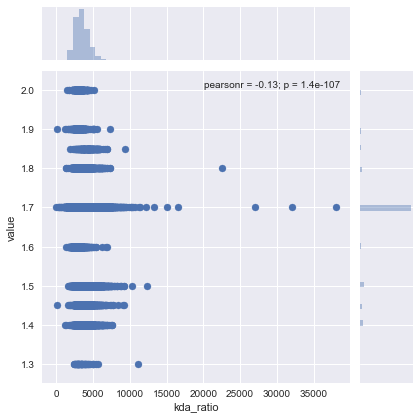

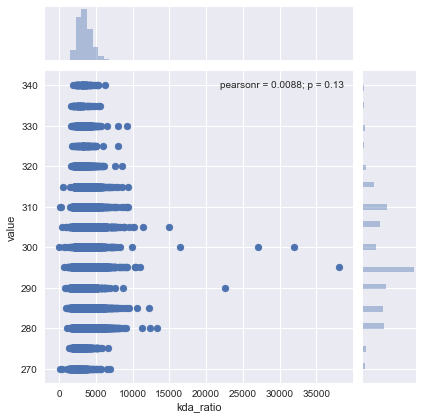

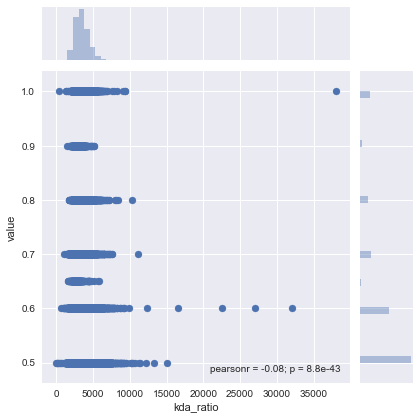

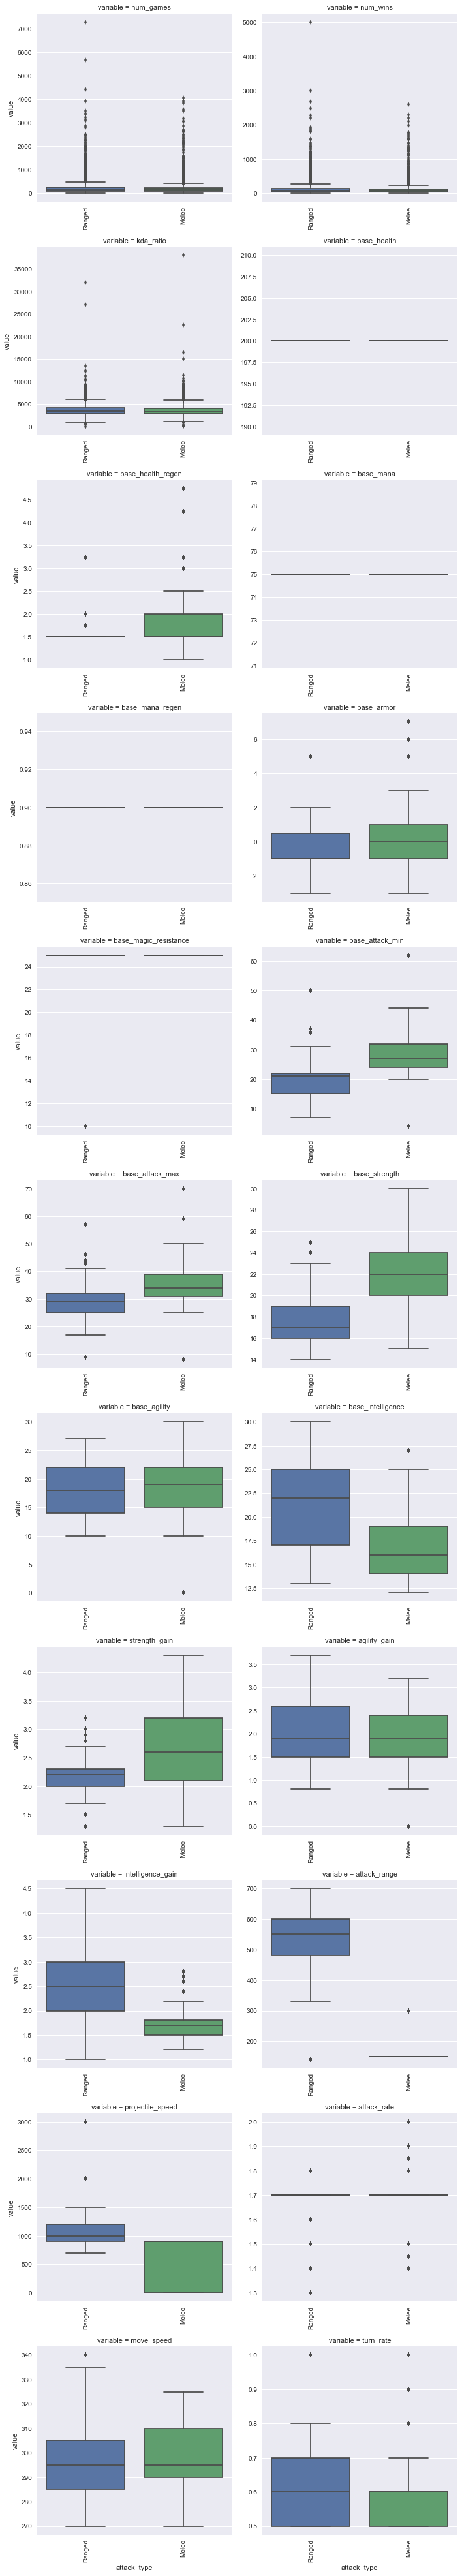

In [87]:
def boxplot(x,y,**kwargs):
            sns.boxplot(x=x,y=y)
            x = plt.xticks(rotation=90)

non_cat = [f for f in train.columns if train.dtypes[f] != 'object']
non_cat.remove('user_id')
non_cat.remove('hero_id')
p = pd.melt(train, id_vars='attack_type', value_vars=non_cat)
g = sns.FacetGrid (p, col='variable', col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, 'attack_type','value')


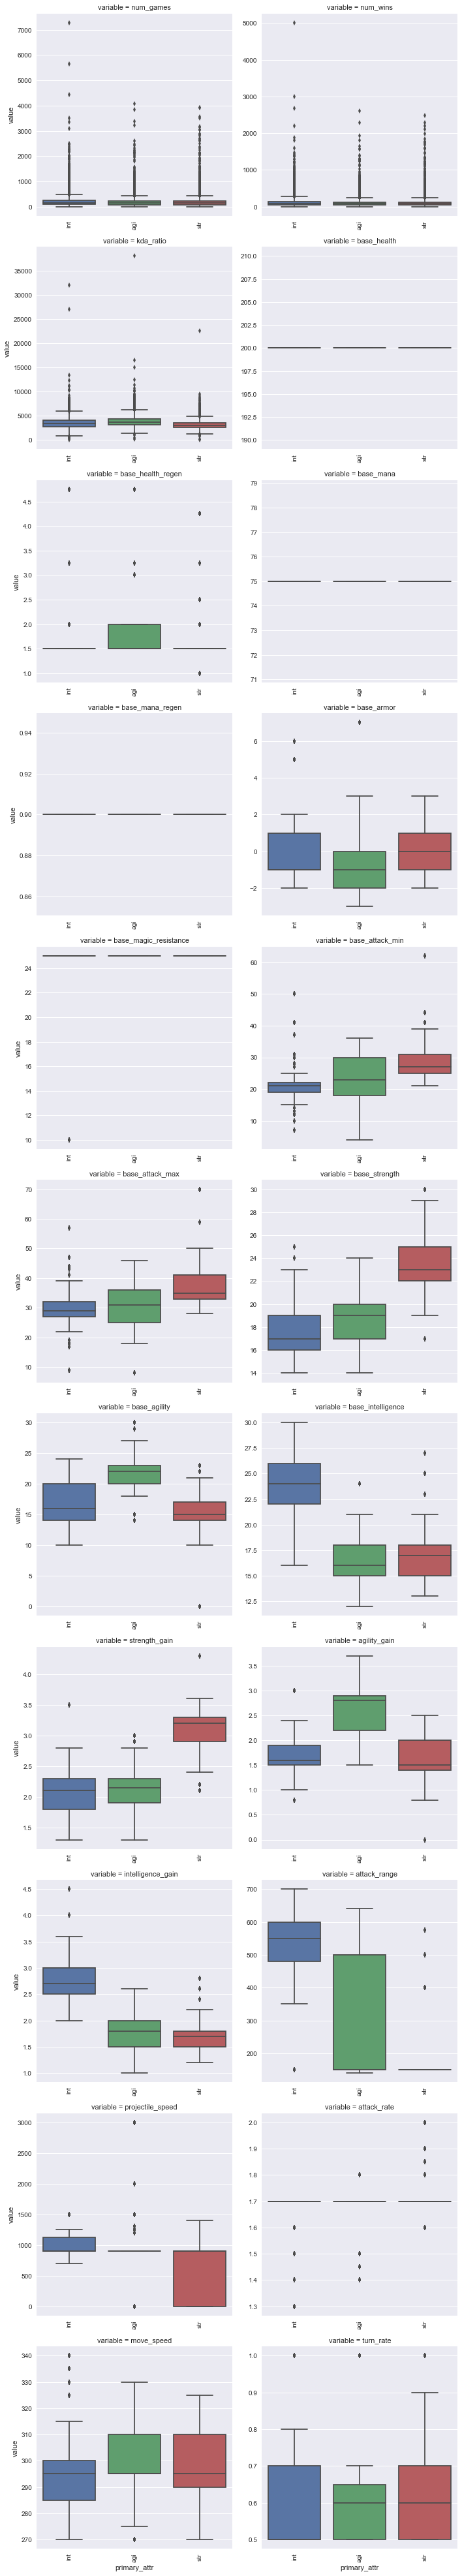

In [88]:
def boxplot(x,y,**kwargs):
            sns.boxplot(x=x,y=y)
            x = plt.xticks(rotation=90)

non_cat = [f for f in train.columns if train.dtypes[f] != 'object']
non_cat.remove('user_id')
non_cat.remove('hero_id')
p = pd.melt(train, id_vars='primary_attr', value_vars=non_cat)
g = sns.FacetGrid (p, col='variable', col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, 'primary_attr','value')
g

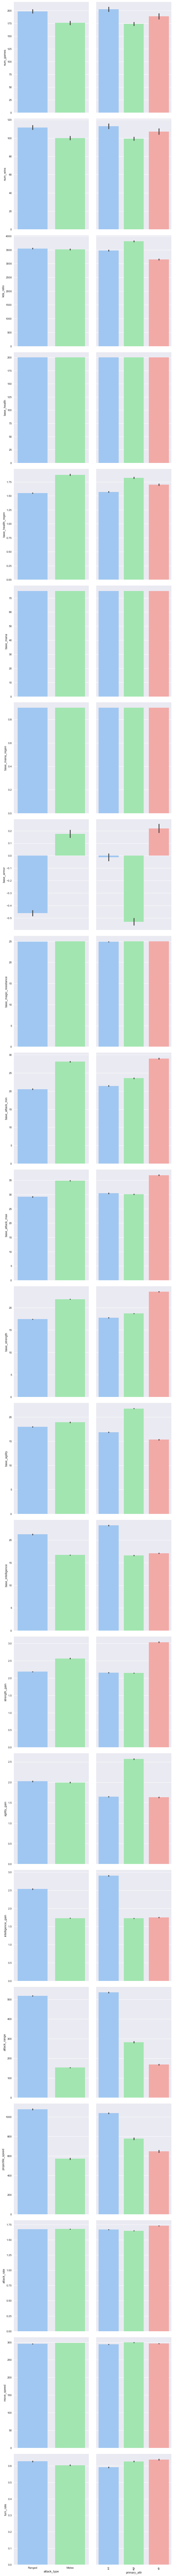

In [89]:
#Uses multiple x and y variables to form pair grid of categorical values passed

non_cat = [f for f in train.columns if train.dtypes[f] != 'object']
non_cat.remove('user_id')
non_cat.remove('hero_id')

g = sns.PairGrid(train,
                 x_vars=["attack_type","primary_attr"],
                 y_vars=non_cat,
                 aspect=.75, size=6)
plt.xticks(rotation=90)
g.map(sns.barplot, palette="pastel");

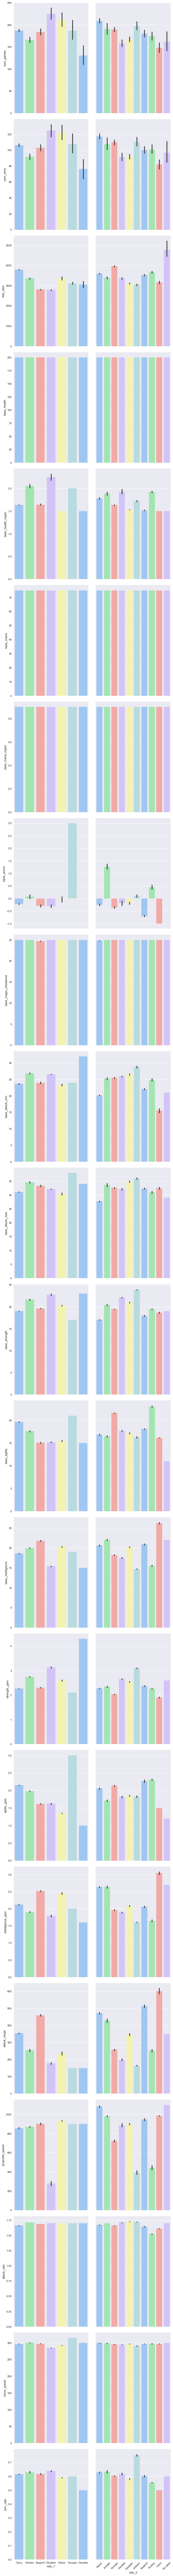

In [91]:
#Uses multiple x and y variables to form pair grid of categorical values passed

non_cat = [f for f in train.columns if train.dtypes[f] != 'object']
non_cat.remove('user_id')
non_cat.remove('hero_id')

g = sns.PairGrid(train,
                 x_vars=["role_1","role_2"],
                 y_vars=non_cat,
                 aspect=.75, size=6)
plt.xticks(rotation=45)
g.map(sns.barplot, palette="pastel");

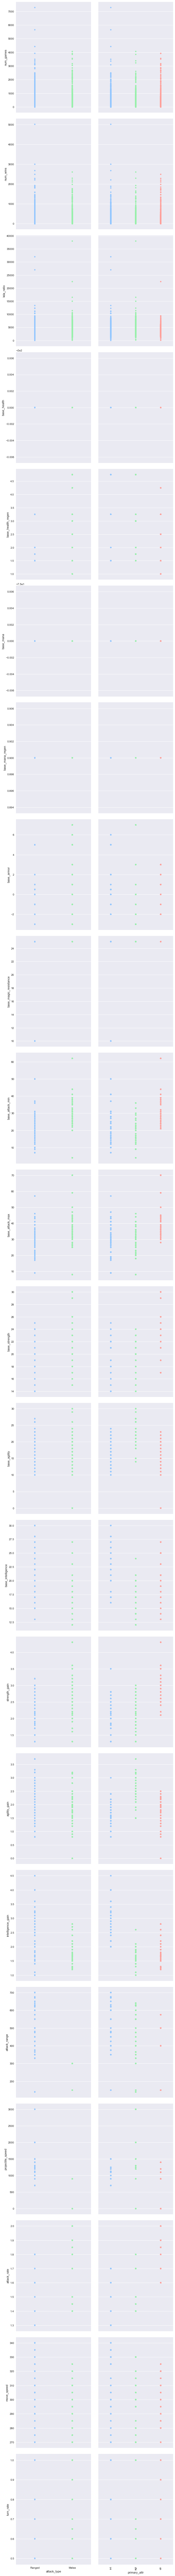

In [90]:
non_cat = [f for f in train.columns if train.dtypes[f] != 'object']
non_cat.remove('user_id')
non_cat.remove('hero_id')

g = sns.PairGrid(train,
                 x_vars=["attack_type","primary_attr"],
                 y_vars=non_cat,
                 aspect=.75, size=6)
plt.xticks(rotation=90)
g.map(sns.stripplot, palette="pastel");

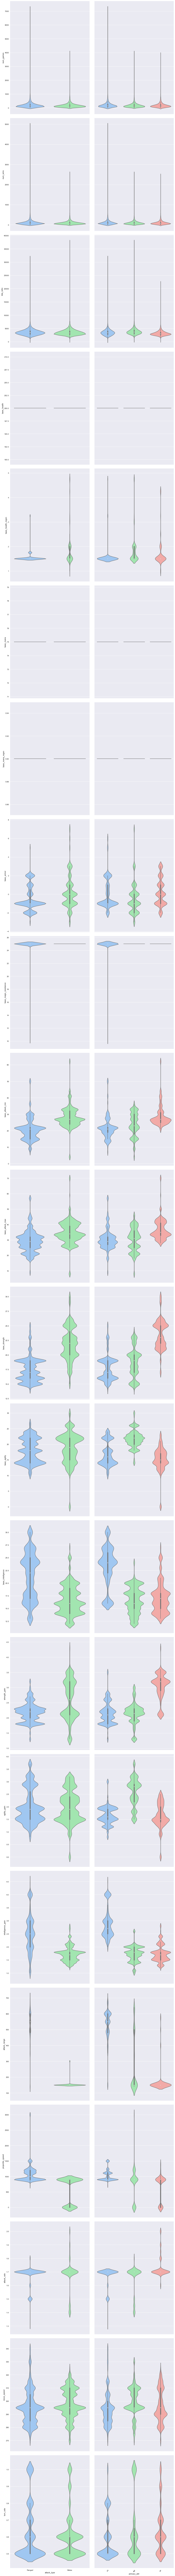

In [92]:
#Uses multiple x and y variables to form pair grid of categorical values passed
non_cat = [f for f in train.columns if train.dtypes[f] != 'object']
non_cat.remove('user_id')
non_cat.remove('hero_id')

g = sns.PairGrid(train,
                 x_vars=["attack_type","primary_attr"],
                 y_vars=non_cat,
                 aspect=0.75, size=9)
plt.xticks(rotation=45)
g.map(sns.violinplot, palette="pastel");

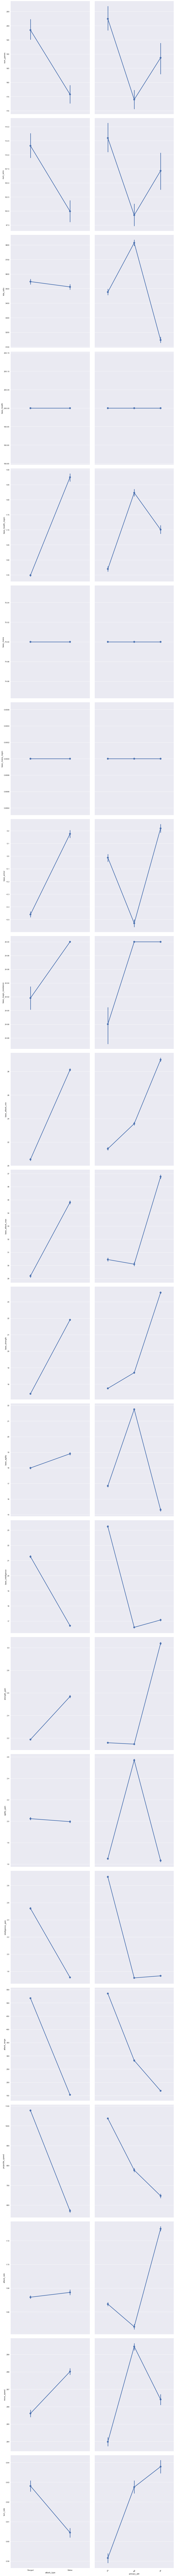

In [93]:
#Uses multiple x and y variables to form pair grid of categorical values passed

non_cat = [f for f in train.columns if train.dtypes[f] != 'object']
non_cat.remove('user_id')
non_cat.remove('hero_id')

g = sns.PairGrid(train,
                 x_vars=["attack_type","primary_attr"],
                 y_vars=non_cat,
                 aspect=0.75, size=9)
plt.xticks(rotation=45)
g.map(sns.pointplot);

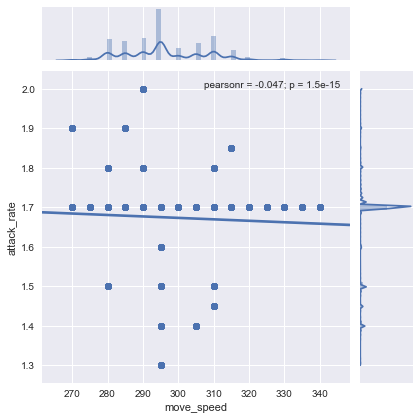

In [94]:
sns.jointplot(x = "move_speed", y="attack_rate", data = train, kind = "reg")

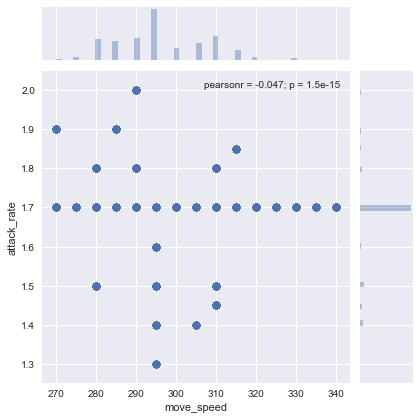

In [95]:
sns.jointplot(x = "move_speed", y="attack_rate", data = train)

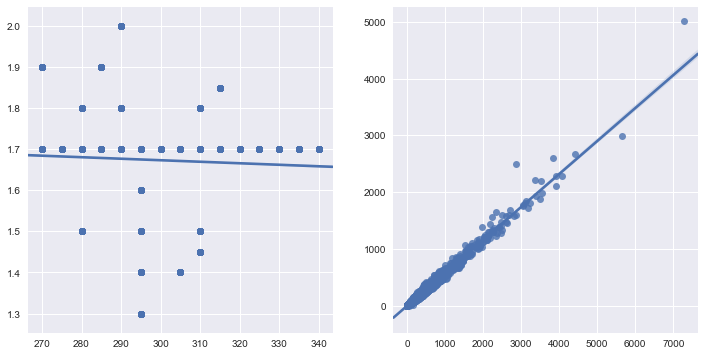

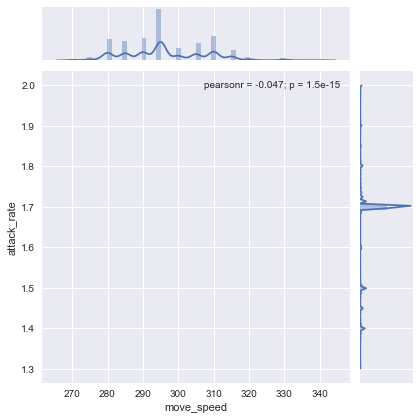

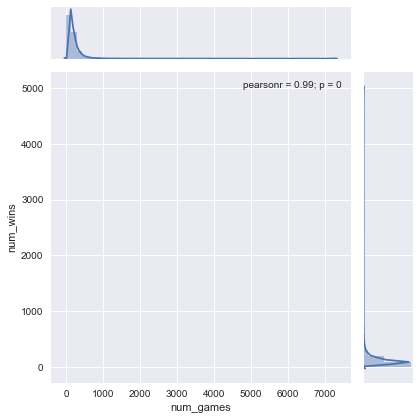

In [96]:
fig, axes = plt.subplots(nrows = 1, ncols=2,figsize=(12,6))

g = sns.jointplot(x = "move_speed", y="attack_rate", data = train, kind = "reg",  ax=axes[0])
g = sns.jointplot(x = "num_games", y="num_wins", data = train, kind = "reg",  ax=axes[1])

plt.tight_layout()
plt.show()
plt.gcf().clear()

In [97]:
dtypes_df = pd.DataFrame()
dtype_df = train.dtypes.reset_index()
dtype_df.columns = ["variable", "type"]
dtype_df

variable     type
0                 user_id    int64
1                 hero_id    int64
2               num_games    int64
3                num_wins    int64
4               kda_ratio  float64
5            primary_attr   object
6             attack_type   object
7             base_health    int64
8       base_health_regen  float64
9               base_mana    int64
10        base_mana_regen  float64
11             base_armor  float64
12  base_magic_resistance    int64
13        base_attack_min    int64
14        base_attack_max    int64
15          base_strength    int64
16           base_agility    int64
17      base_intelligence    int64
18          strength_gain  float64
19           agility_gain  float64
20      intelligence_gain  float64
21           attack_range    int64
22       projectile_speed    int64
23            attack_rate  float64
24             move_speed    int64
25              turn_rate  float64
26                 role_1   object
27                 role_2   object
28                 role_3   object
29                 role_4   object
30                 role_5   object
31                 role_6   object

In [98]:
dtype_df.groupby("type").aggregate('count').reset_index()

type  variable
0    int64        15
1  float64         9
2   object         8

In [ ]:
correlation = data.corr()
plt.figure(figsize=(38,14))
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='terrain')
plt.title('Correlation between different fearures' )

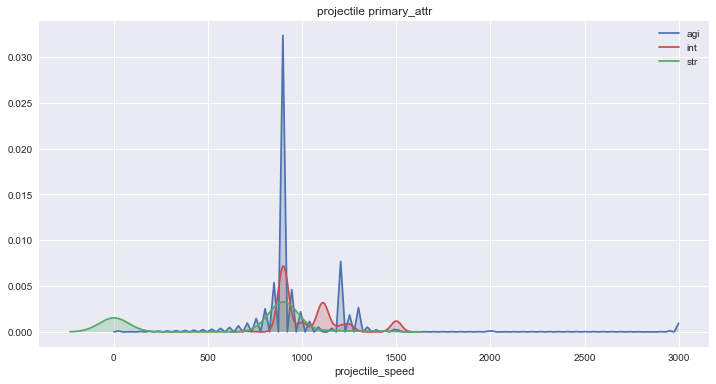

In [99]:
fig = plt.figure(figsize=(12,6),)
ax=sns.kdeplot(train.loc[(train['primary_attr'] == 'agi'),'projectile_speed'] , color='b',shade=True,label='agi')
ax=sns.kdeplot(train.loc[(train['primary_attr'] == 'int'),'projectile_speed'] , color='r',shade=True, label='int')
ax=sns.kdeplot(train.loc[(train['primary_attr'] == 'str'),'projectile_speed'] , color='g',shade=True, label='str')
plt.xlabel("projectile_speed")
plt.title('projectile primary_attr')

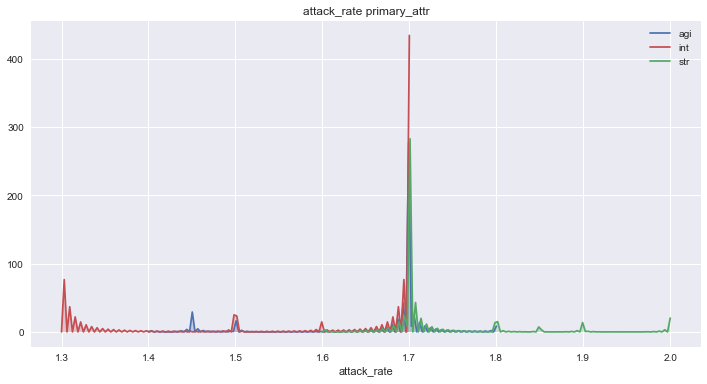

In [100]:
fig = plt.figure(figsize=(12,6),)
ax=sns.kdeplot(train.loc[(train['primary_attr'] == 'agi'),'attack_rate'] , color='b',shade=True,label='agi')
ax=sns.kdeplot(train.loc[(train['primary_attr'] == 'int'),'attack_rate'] , color='r',shade=True, label='int')
ax=sns.kdeplot(train.loc[(train['primary_attr'] == 'str'),'attack_rate'] , color='g',shade=True, label='str')
plt.xlabel("attack_rate")
plt.title('attack_rate primary_attr')

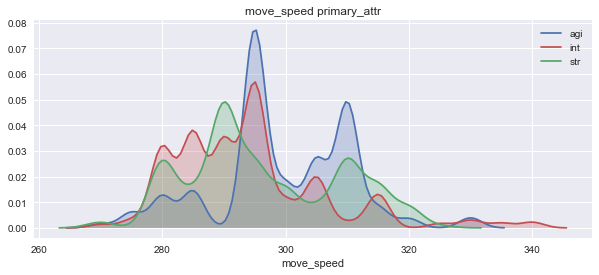

In [101]:
fig = plt.figure(figsize=(10,4),)
ax=sns.kdeplot(train.loc[(train['primary_attr'] == 'agi'),'move_speed'] , color='b',shade=True,label='agi')
ax=sns.kdeplot(train.loc[(train['primary_attr'] == 'int'),'move_speed'] , color='r',shade=True, label='int')
ax=sns.kdeplot(train.loc[(train['primary_attr'] == 'str'),'move_speed'] , color='g',shade=True, label='str')
plt.xlabel("move_speed")
plt.title('move_speed primary_attr')

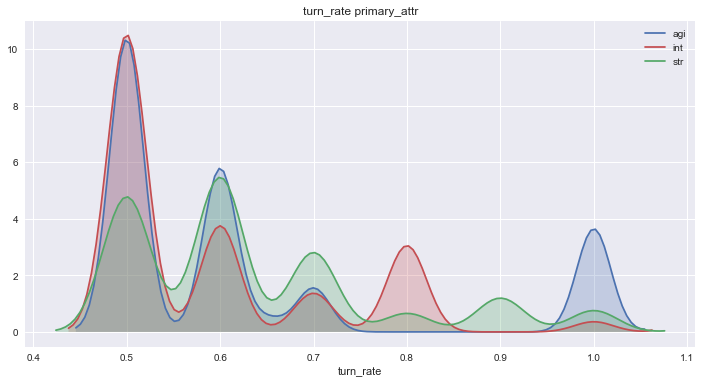

In [102]:
fig = plt.figure(figsize=(12,6),)
ax=sns.kdeplot(train.loc[(train['primary_attr'] == 'agi'),'turn_rate'] , color='b',shade=True,label='agi')
ax=sns.kdeplot(train.loc[(train['primary_attr'] == 'int'),'turn_rate'] , color='r',shade=True, label='int')
ax=sns.kdeplot(train.loc[(train['primary_attr'] == 'str'),'turn_rate'] , color='g',shade=True, label='str')
plt.xlabel("turn_rate")
plt.title('turn_rate primary_attr')

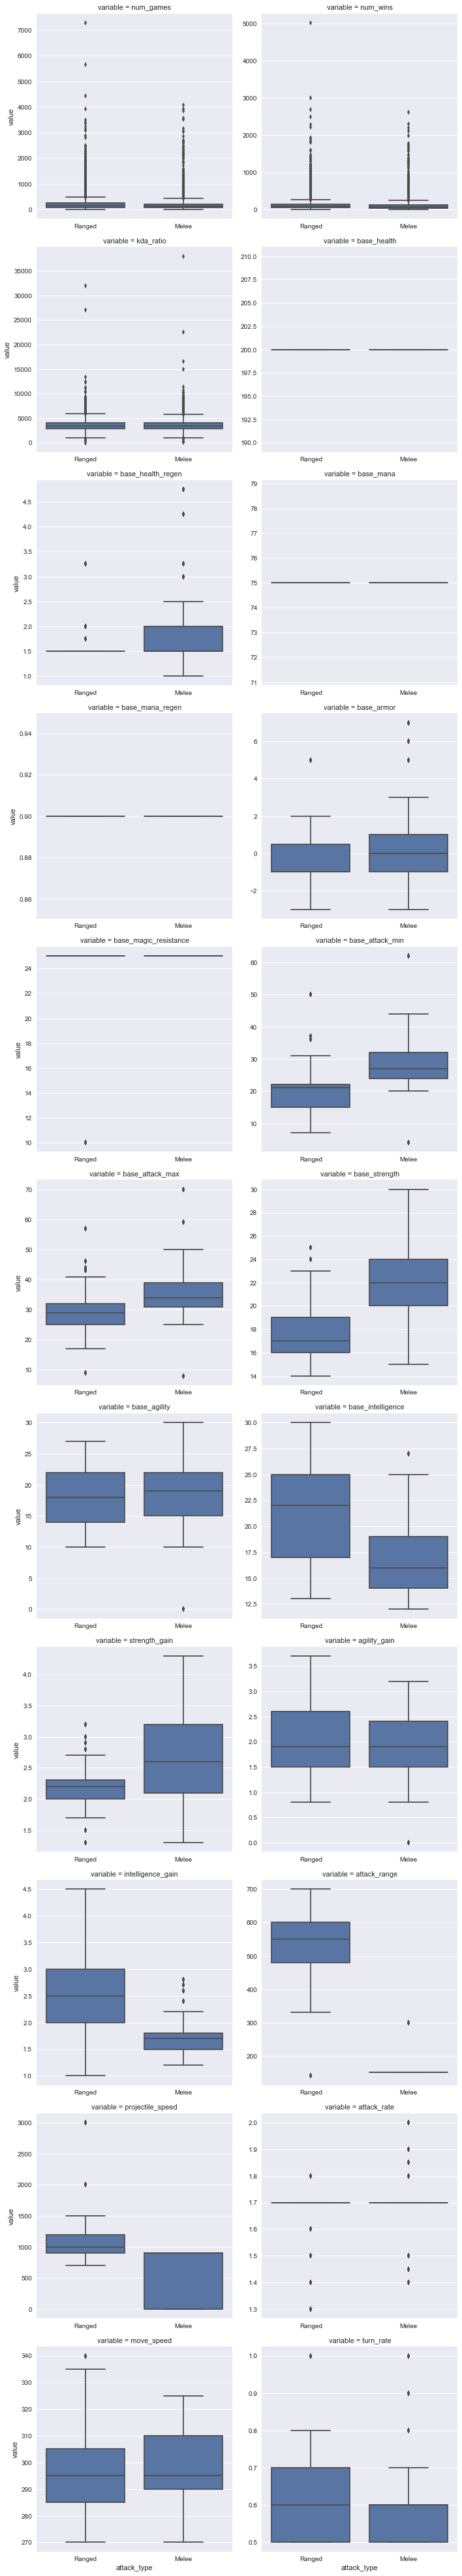

In [103]:
non_cat = [f for f in train.columns if train.dtypes[f] != 'object']
non_cat.remove('user_id')
non_cat.remove('hero_id')
p = pd.melt(train, id_vars='attack_type', value_vars=non_cat)
g = sns.FacetGrid (p, col='variable', col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(sns.boxplot,'attack_type', 'value')
g

C:\Users\Architect_shwet\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\Users\Architect_shwet\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


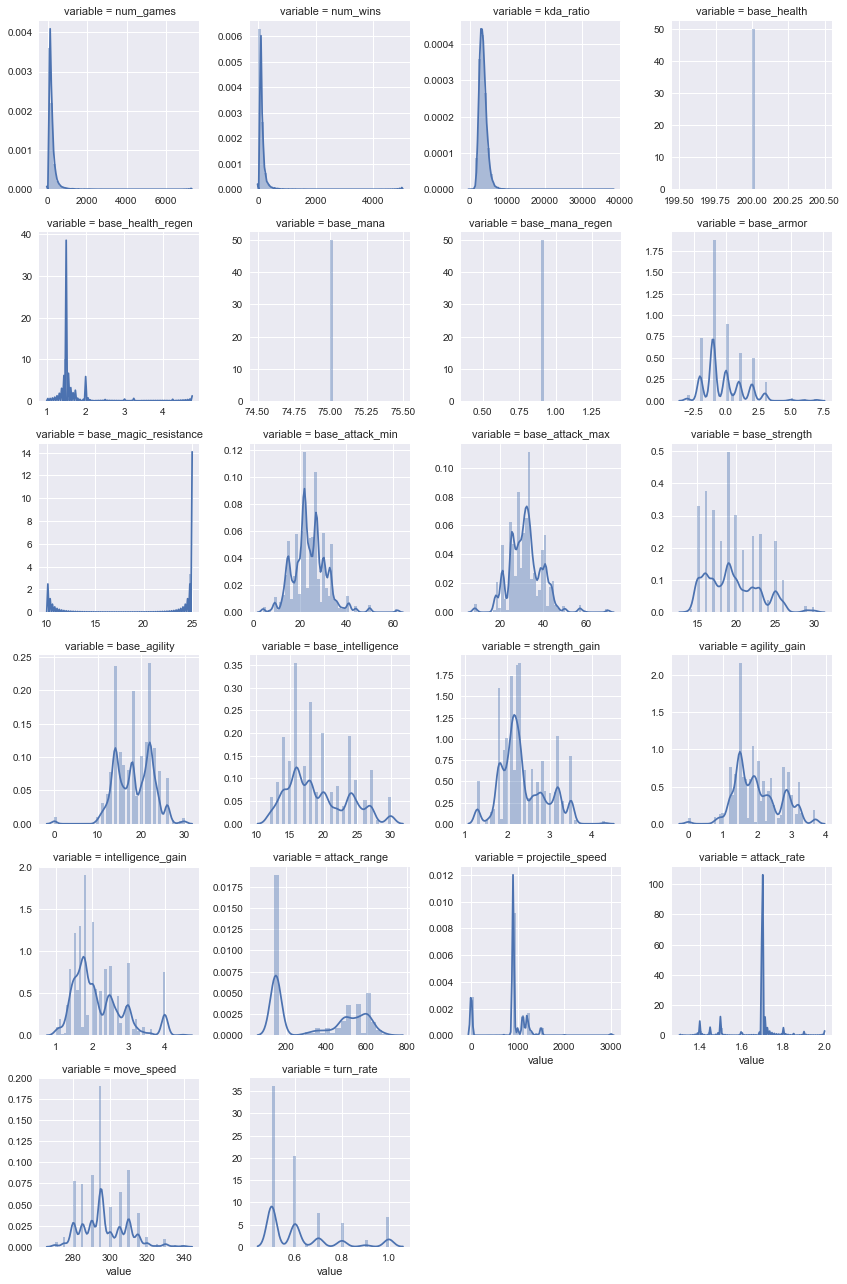

In [104]:
#create numeric plots
num = [f for f in train.columns if train.dtypes[f] != 'object']

num.remove('user_id')
num.remove('hero_id')

nd = pd.melt(train, value_vars = num)
n1 = sns.FacetGrid (nd, col='variable', col_wrap=4, sharex=False, sharey = False)
n1 = n1.map(sns.distplot, 'value')
n1

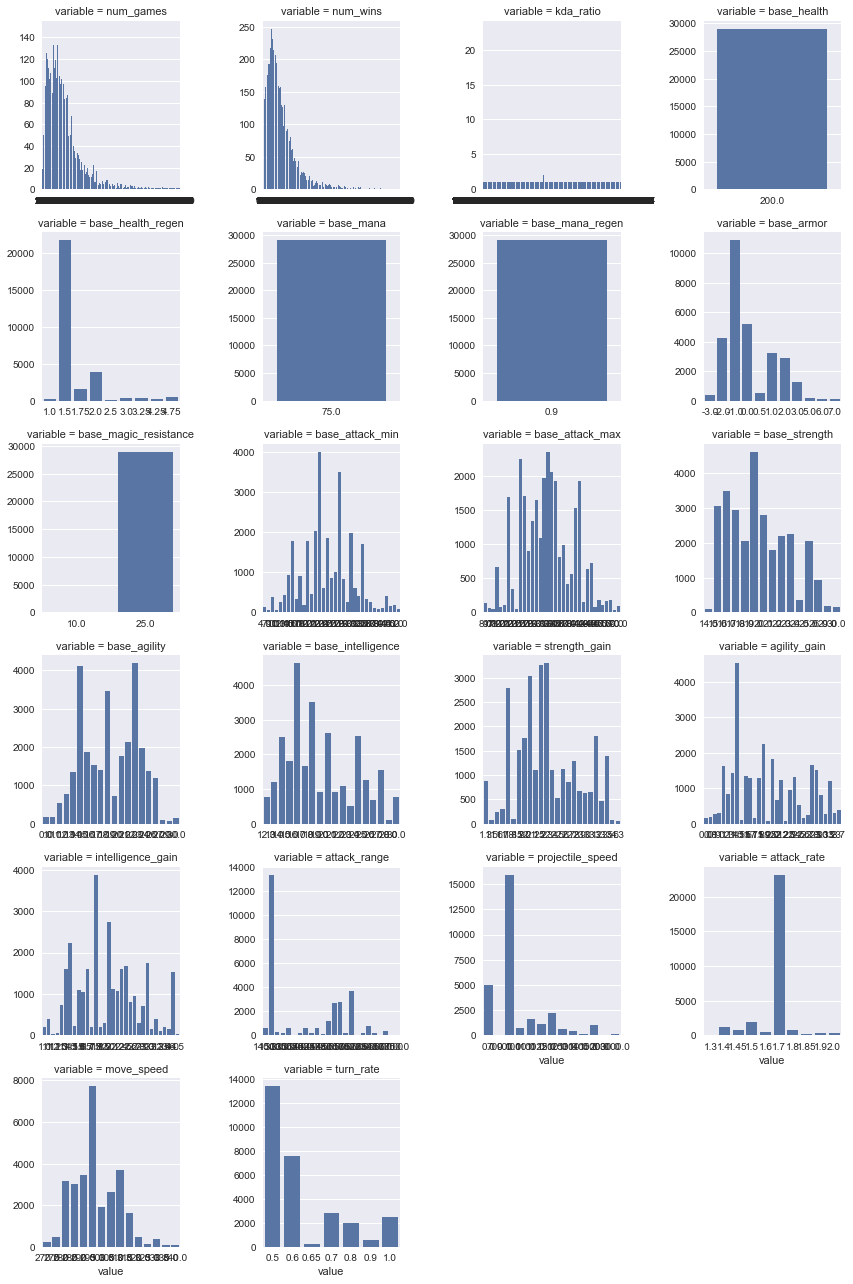

In [105]:
#create numeric plots
num = [f for f in train.columns if train.dtypes[f] != 'object']

num.remove('user_id')
num.remove('hero_id')

nd = pd.melt(train, value_vars = num)
n1 = sns.FacetGrid (nd, col='variable', col_wrap=4, sharex=False, sharey = False)
n1 = n1.map(sns.countplot, 'value')
n1

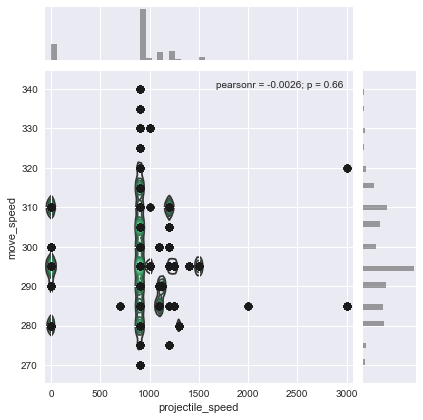

In [115]:
plt.figure(figsize=(16,16))
g = (sns.jointplot("projectile_speed", "move_speed",data=train, color="k").plot_joint(sns.kdeplot, zorder=0))

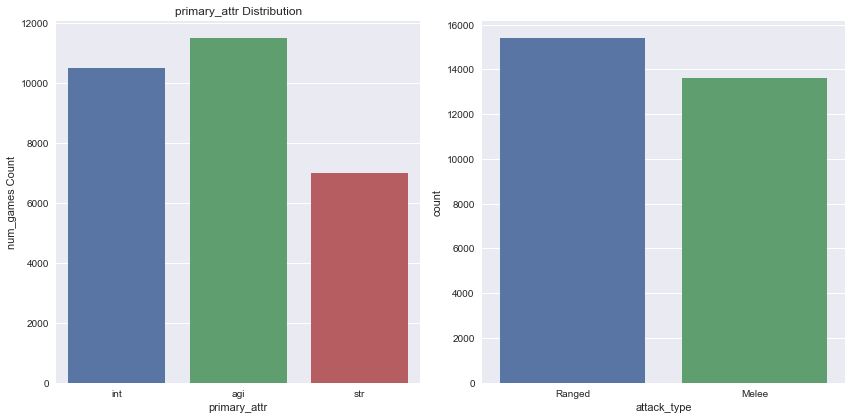

In [116]:
fig, axes = plt.subplots(ncols=2,figsize=(12,6))

g = sns.countplot(train["primary_attr"], ax=axes[0]).set_title('primary_attr Distribution')
axes[0].set_ylabel('num_games Count')
#plt.setp(g.get_xticklabels(), rotation=45)
g = sns.countplot(train["attack_type"], ax=axes[1])

plt.tight_layout()
plt.show()
plt.gcf().clear()

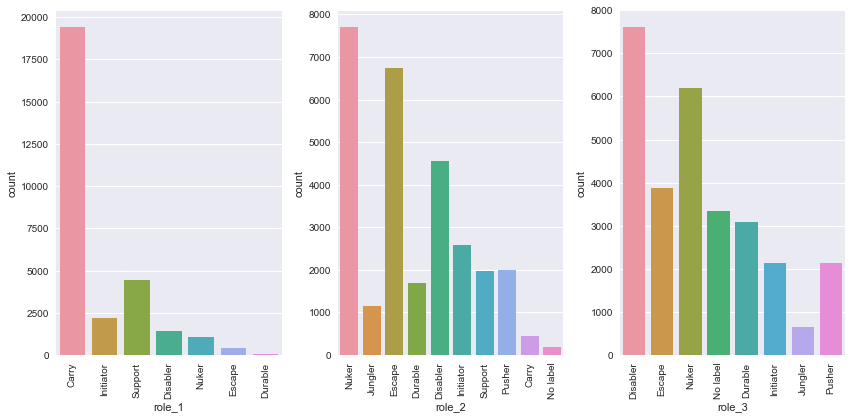

In [117]:
fig, axes = plt.subplots(ncols=3,figsize=(12,6))

g = sns.countplot(train["role_1"], ax=axes[0])
plt.setp(g.get_xticklabels(), rotation=90)
g = sns.countplot(train["role_2"], ax=axes[1])
plt.setp(g.get_xticklabels(), rotation=90)
g = sns.countplot(train["role_3"], ax=axes[2])
plt.setp(g.get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()
plt.gcf().clear()

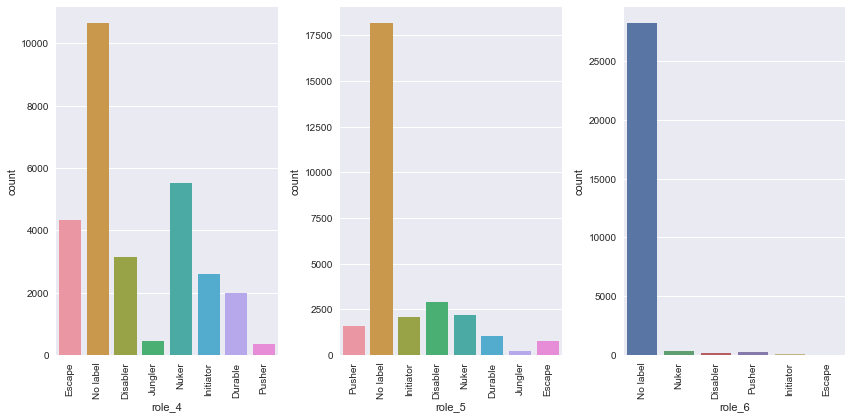

In [118]:
fig, axes = plt.subplots(ncols=3,figsize=(12,6))

g = sns.countplot(train["role_4"], ax=axes[0])
plt.setp(g.get_xticklabels(), rotation=90)
g = sns.countplot(train["role_5"], ax=axes[1])
plt.setp(g.get_xticklabels(), rotation=90)
g = sns.countplot(train["role_6"], ax=axes[2])
plt.setp(g.get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()
plt.gcf().clear()

C:\Users\Architect_shwet\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\Users\Architect_shwet\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


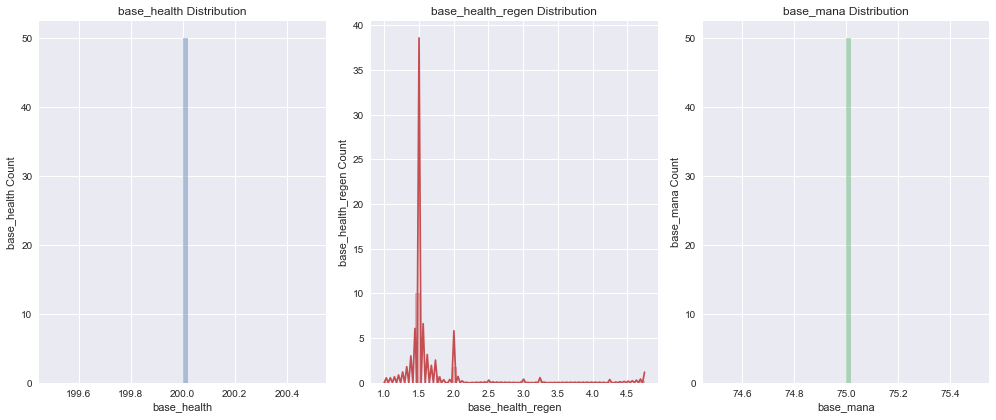

In [120]:
flg, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (14,6))

sns.distplot(train['base_health'], ax = axes[0]).set_title('base_health Distribution')
axes[0].set_ylabel('base_health Count')

sns.distplot(train['base_health_regen'], color = "r", ax = axes[1]).set_title('base_health_regen Distribution')
axes[1].set_ylabel('base_health_regen Count')

sns.distplot(train['base_mana'], color = "g", ax = axes[2]).set_title('base_mana Distribution')
axes[2].set_ylabel('base_mana Count')

plt.tight_layout()
plt.show()

C:\Users\Architect_shwet\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\Users\Architect_shwet\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


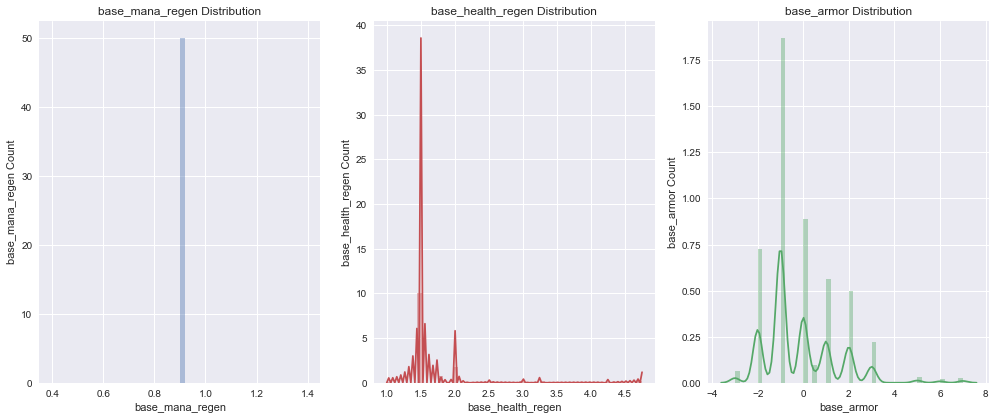

In [121]:
flg, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (14,6))

sns.distplot(train['base_mana_regen'], ax = axes[0]).set_title('base_mana_regen Distribution')
axes[0].set_ylabel('base_mana_regen Count')

sns.distplot(train['base_health_regen'], color = "r", ax = axes[1]).set_title('base_health_regen Distribution')
axes[1].set_ylabel('base_health_regen Count')

sns.distplot(train['base_armor'],color = "g", ax = axes[2]).set_title('base_armor Distribution')
axes[2].set_ylabel('base_armor Count')

plt.tight_layout()
plt.show()
plt.gcf().clear()

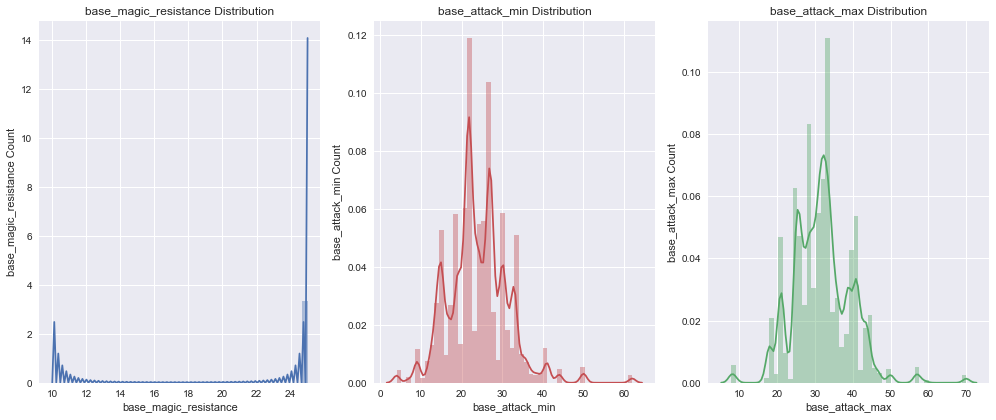

In [122]:
flg, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (14,6))

sns.distplot(train['base_magic_resistance'], ax = axes[0]).set_title('base_magic_resistance Distribution')
axes[0].set_ylabel('base_magic_resistance Count')

sns.distplot(train['base_attack_min'], color = "r", ax = axes[1]).set_title('base_attack_min Distribution')
axes[1].set_ylabel('base_attack_min Count')

sns.distplot(train['base_attack_max'],color = "g", ax = axes[2]).set_title('base_attack_max Distribution')
axes[2].set_ylabel('base_attack_max Count')

plt.tight_layout()
plt.show()
plt.gcf().clear()

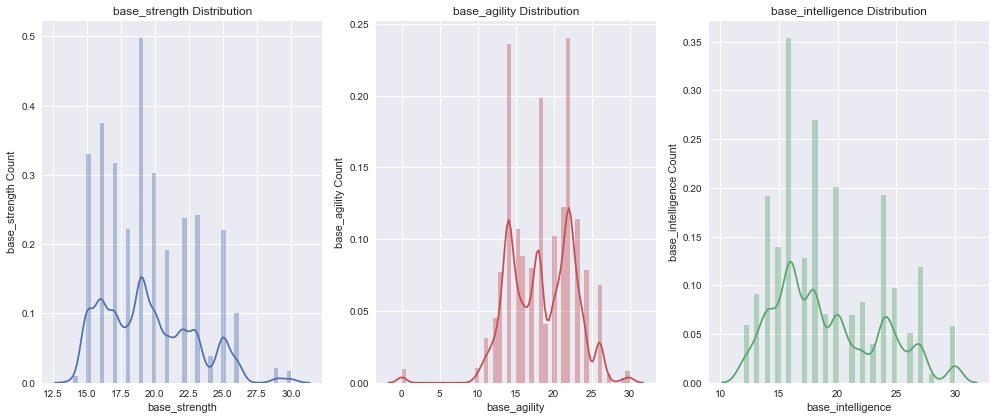

In [123]:
flg, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (14,6))

sns.distplot(train['base_strength'], ax = axes[0]).set_title('base_strength Distribution')
axes[0].set_ylabel('base_strength Count')

sns.distplot(train['base_agility'], color = "r", ax = axes[1]).set_title('base_agility Distribution')
axes[1].set_ylabel('base_agility Count')

sns.distplot(train['base_intelligence'],color = "g", ax = axes[2]).set_title('base_intelligence Distribution')
axes[2].set_ylabel('base_intelligence Count')

plt.tight_layout()
plt.show()
plt.gcf().clear()

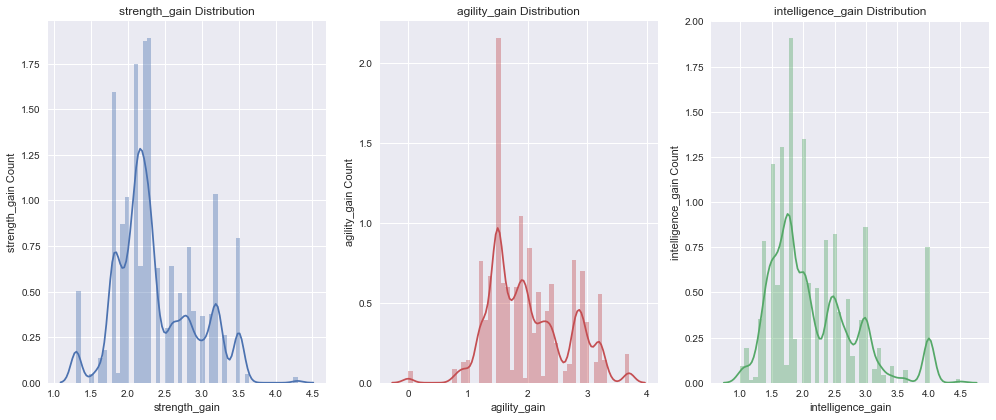

In [124]:
flg, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (14,6))

sns.distplot(train['strength_gain'], ax = axes[0]).set_title('strength_gain Distribution')
axes[0].set_ylabel('strength_gain Count')

sns.distplot(train['agility_gain'], color = "r", ax = axes[1]).set_title('agility_gain Distribution')
axes[1].set_ylabel('agility_gain Count')

sns.distplot(train['intelligence_gain'],color = "g", ax = axes[2]).set_title('intelligence_gain Distribution')
axes[2].set_ylabel('intelligence_gain Count')

plt.tight_layout()
plt.show()
plt.gcf().clear()

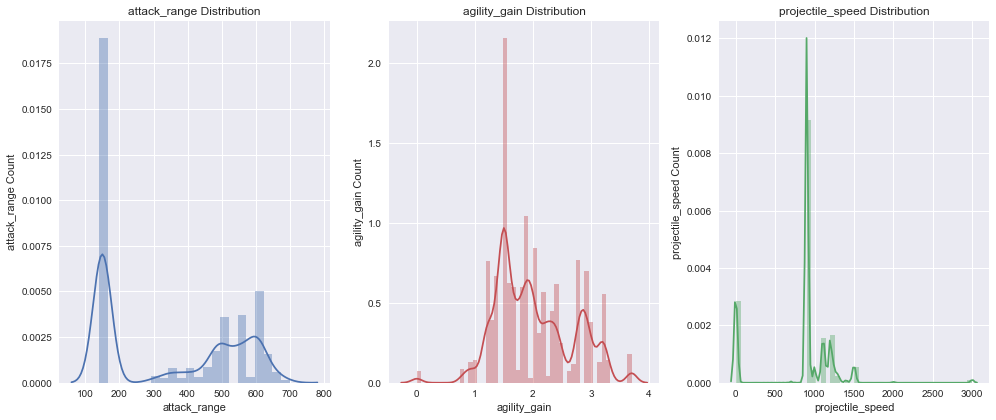

In [125]:
flg, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (14,6))

sns.distplot(train['attack_range'], ax = axes[0]).set_title('attack_range Distribution')
axes[0].set_ylabel('attack_range Count')

sns.distplot(train['agility_gain'], color = "r", ax = axes[1]).set_title('agility_gain Distribution')
axes[1].set_ylabel('agility_gain Count')

sns.distplot(train['projectile_speed'],color = "g", ax = axes[2]).set_title('projectile_speed Distribution')
axes[2].set_ylabel('projectile_speed Count')

plt.tight_layout()
plt.show()
plt.gcf().clear()

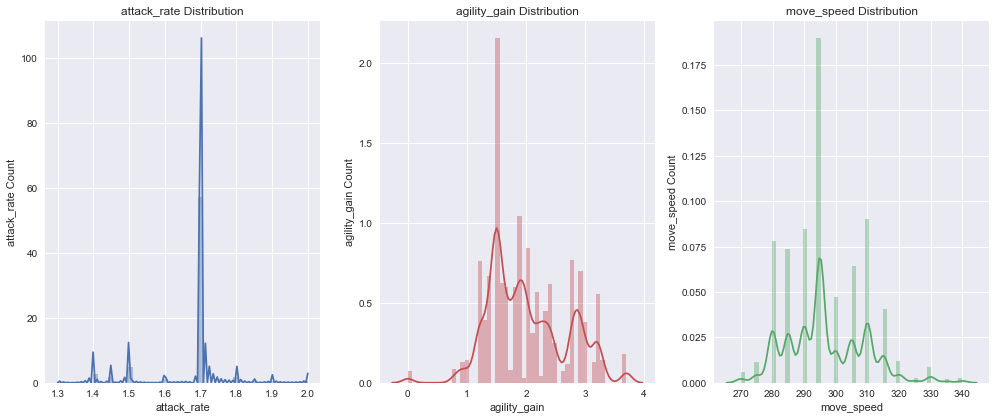

In [126]:
flg, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (14,6))

sns.distplot(train['attack_rate'], ax = axes[0]).set_title('attack_rate Distribution')
axes[0].set_ylabel('attack_rate Count')

sns.distplot(train['agility_gain'], color = "r", ax = axes[1]).set_title('agility_gain Distribution')
axes[1].set_ylabel('agility_gain Count')

sns.distplot(train['move_speed'],color = "g", ax = axes[2]).set_title('move_speed Distribution')
axes[2].set_ylabel('move_speed Count')

plt.tight_layout()
plt.show()
plt.gcf().clear()

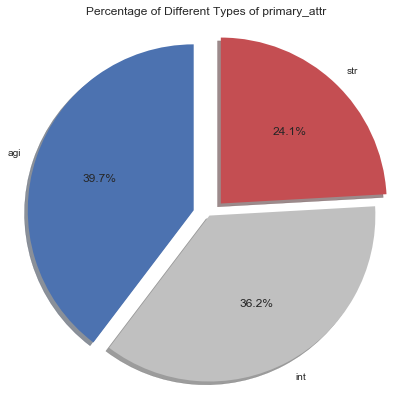

In [127]:
labels = 'agi', 'int', 'str'
sizes = [11513, 10513, 6996]
colors = ['B', 'silver', 'R']
explode = (0.1, 0.0, 0.1) 
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.title("Percentage of Different Types of primary_attr")
plt.plot()
fig=plt.gcf()
fig.set_size_inches(7,7)
plt.show()

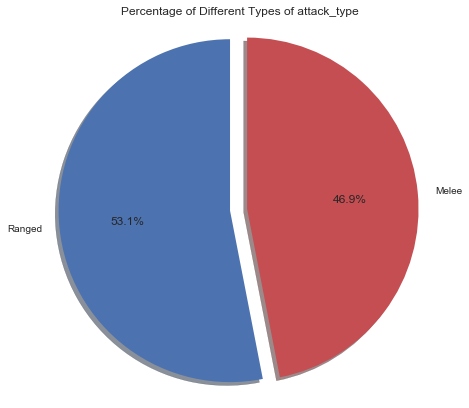

In [128]:
labels = 'Ranged', 'Melee'
sizes = [15400, 13622]
colors = ['B', 'R']
explode = (0.1, 0.0) 
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.title("Percentage of Different Types of attack_type")
plt.plot()
fig=plt.gcf()
fig.set_size_inches(7,7)
plt.show()

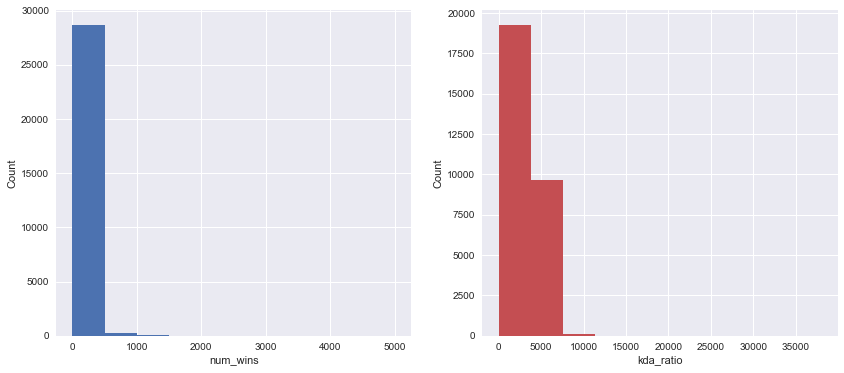

In [129]:
flg, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (14,6))

axes[0].hist(train['num_wins'])
axes[0].set_xlabel("num_wins")
axes[0].set_ylabel("Count")

axes[1].hist(train['kda_ratio'], color = "r")
axes[1].set_xlabel("kda_ratio")
axes[1].set_ylabel("Count")


In [ ]:
train = train.drop('num_wins', axis = 1)

In [ ]:

from xgboost import XGBRegressor
model = XGBRegressor(colsample_bytree=0.2,
                        gamma=0.0,
                        learning_rate=0.05,
                        max_depth=3,
                        min_child_weight=1.5,
                        n_estimators=50,#50,000
                        reg_alpha=0.3,
                        reg_lambda=0.6,
                       subsample=0.8,
                      seed=42,
                      silent=1)

model.fit(train[feature_names], target)
pred_xgb = model.predict(test[feature_names])

In [ ]:
model = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                  min_samples_leaf=15, min_samples_split=10, 
                                    loss='huber', random_state =5)
model.fit(train[feature_names], target)
pred_rf = model.predict(test[feature_names])
pred_rf[:10]

In [ ]:
model = RandomForestRegressor()
model.fit(train[feature_names], target)
pred_rf = model.predict(test[feature_names])